## Imports

In [ ]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F

from surrogates4sims.datasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest

from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage

#from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

from surrogates4sims.svd import MantaFlowSVDDataset

import numpy as np
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

## Settings

In [ ]:
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "LIN_SVD_only_z_and_p_LSTM_bidirec"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "2"#,1,2,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = True  
patience = 10

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 4
numSamplesToKeep = np.infty #if not debugging
latentDim = 512
simLen = 200
simVizIndex = 0 # sim in the test set to visualize
numComponents = latentDim
transform = True
if DEBUG:
    epochs = 5000
    numSamplesToKeep = 1000
    
versionName = versionName + '_latentDim{}_bz{}_transform{}_epochs{}'.format(latentDim,bz,transform,epochs)
versionName

'LIN_SVD_only_z_and_p_LSTM_bidirec_GPUs2_latentDim512_bz4_transformTrue_epochs1000'

### Select Personal GPUs

In [ ]:
!nvidia-smi

Mon Aug 24 17:11:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   25C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [ ]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [ ]:
if device.type == 'cuda':
    print(cuda.is_available())
    print(cuda.device_count())
    print(cuda.current_device())
    print(cuda.get_device_name())

True
1
0
TITAN Xp


In [ ]:
a = torch.zeros(5, device=device.type)
!nvidia-smi

Mon Aug 24 17:11:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            On   | 00000000:02:00.0 Off |                  N/A |
| 23%   20C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN Xp            On   | 00000000:03:00.0 Off |                  N/A |
| 23%   25C    P8     8W / 250W |      1MiB / 12196MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## Datasets & Loaders

In [ ]:
# A = np.load('svd_out.npz')
# vh = A['arr_2']
# vh.shape
# data = []
# numComp = 512
# for idx in range(105):
#     D = getSingleSim(idx)
#     simDataset = MantaFlowDataset(D)
#     Z = []
#     P = []
#     X0, p = simDataset[0]
#     for sample in simDataset:
#         f, p = sample
#         coeffs = vh[:numComp]@f.flatten()
#         Z.append(coeffs)
#         P.append(p)
#     y = np.array(Z)
#     P = np.array(P)
#     X = (X0,P,y[0])
#     data.append((X,y[1:]))
# with open('simLatentVectors.pkl','wb') as fid:
#     pickle.dump(data,fid)    

In [ ]:
import pickle
with open('simLatentVectors.pkl','rb') as fid:
    data = pickle.load(fid)
len(data)

105

In [ ]:
data[0][0][0].shape, data[0][0][1].shape, data[0][0][2].shape, data[0][1].shape

((2, 128, 96), (200, 3), (512,), (199, 512))

In [ ]:
trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
print((len(trainData),len(testData)))

(19000, 2000)


In [ ]:
from glob import glob
d = glob(os.path.join(dataDirec,'*.npz'))
d = sorted(d)
simLen = 200
numSims = len(d)//simLen
numTestSamples = int(np.round(testSplit*numSims))
np.random.seed(seed)
perm = np.random.permutation(numSims)
testSims = perm[:numTestSamples]
trainSims = perm[numTestSamples:]
testSims, trainSims

(array([32, 57, 90, 63, 66, 79, 61, 48, 39, 62]),
 array([ 42,  88,  99,  54, 101,  40,  29,  51,  27,  35,  93,  17,  92,
          1,  77,  78,   9,  20,  72,  33,  55,  96,  71,  25,  85,   4,
         68,  10,  52,  98,   5,  84,  36,   7,  81,  64, 103,  82,  89,
         21,  18,  97,  86,  74,  91,  59,  22,  70,   6,  44,  56,   8,
         41,  16,  45,  31,  87,  13,  28,  46,  60,  14,  65,  12,  19,
          2,   3,  75,   0,  11,  67, 102,  34,  37, 100,  50, 104,  73,
         80,  69,  58,  95,  94,  43,  30,  26,  23,  49,  15,  24,  76,
         53,  38,  83,  47]))

In [ ]:
testDataset = [data[i] for i in testSims]
trainDataset = [data[i] for i in trainSims]
len(testDataset), len(trainDataset)

(10, 95)

In [ ]:
D = []
E = []
for X,y in trainDataset:
    z = X[2]
    z = z.reshape(1,len(z))
    y = np.concatenate([z,y])
    D.append(y.max(axis=0))
    E.append(y.min(axis=0))
D = np.array(D)
E = np.array(E)
ymx = D.max(axis=0)
ymn = E.min(axis=0)
ymx, ymn

(array([32.42237   , 31.673756  , 15.945324  , 16.820152  , 10.968686  ,
        11.164314  , 12.551913  ,  9.661632  ,  8.658076  ,  8.009456  ,
         9.385018  ,  7.821459  ,  8.565533  ,  5.8345957 ,  9.973234  ,
         5.7962904 ,  5.924981  ,  6.3525286 ,  5.2967076 ,  5.6366234 ,
         6.2708244 ,  4.8153677 ,  4.9387937 ,  3.8268383 ,  4.6776466 ,
         4.3764625 ,  4.733694  ,  4.09702   ,  4.2068624 ,  4.0729527 ,
         3.7261138 ,  3.905477  ,  3.4484649 ,  3.9954464 ,  5.0817056 ,
         3.3907788 ,  3.4920232 ,  3.2606559 ,  3.7830772 ,  3.5627594 ,
         4.188346  ,  4.086383  ,  3.8826456 ,  3.0903916 ,  3.075858  ,
         3.21513   ,  2.9283023 ,  3.1073725 ,  4.0672874 ,  3.1148481 ,
         3.0471787 ,  3.0873415 ,  3.6653297 ,  2.980827  ,  2.6250737 ,
         2.3686075 ,  3.2206206 ,  3.1710668 ,  3.324367  ,  3.326931  ,
         2.5324607 ,  3.2264695 ,  2.5638535 ,  2.9850056 ,  2.1061535 ,
         2.6369638 ,  2.2873755 ,  3.146889  ,  3.2

In [ ]:
def transformY(y,ymx,ymn):
    return (ymx - y)/(ymx - ymn)

def inverseTransformY(y,ymx,ymn):
    x = ymx - y*(ymx - ymn)
    return x

In [ ]:
a = transformY(y,ymx,ymn)
a.max(), a.min()

(1.0, 0.0)

In [ ]:
b = inverseTransformY(a,ymx,ymn)
np.abs(y - b).max()

2.861023e-06

In [ ]:
import random

class LatentSVD30(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
                 
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx, return_norm_stats=False):
        X, y  = self.data[idx]
        p = X[1]
        z = X[2]

        if self.transform:
            y = torch.tensor(y)
            norm_stats = y.norm(dim=1).unsqueeze(1)
            y = y / norm_stats
            
        D = []
        for pp in p[1:]:
            zz = np.concatenate([pp,z])#.reshape(1,515)
            D.append(zz)
        X = np.array(D)

        X = torch.tensor(X[:, :3])
        inits = torch.cat([torch.tensor(z).unsqueeze(0), y[:-1]])
        X = torch.cat([X, inits], dim=1)
        
        y = y[31:]
        
        if return_norm_stats:
            return X, y, norm_stats
        else:
            return X, y

In [ ]:
if transform:
    testDataset = LatentSVD30(testDataset, transform=transformY)
    trainDataset = LatentSVD30(trainDataset, transform=transformY)
else:
    testDataset = LatentSVD30(testDataset)
    trainDataset = LatentSVD30(trainDataset)

### Making sure the transform works

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=1, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=1)

In [ ]:
X,y = next(iter(trainDataLoader))
X.shape, y.shape

(torch.Size([1, 199, 515]), torch.Size([1, 168, 512]))

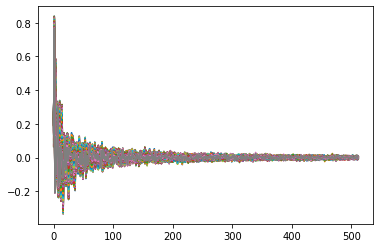

In [ ]:
plt.plot(y[0].squeeze().T)
plt.show()

In [ ]:
y.max(), y.min()

(tensor(0.8385), tensor(-0.3343))

In [ ]:
X.shape

torch.Size([1, 199, 515])

In [ ]:
X[:,:,3:].max(),X[:,:,3:].min()

(tensor(0.8385), tensor(-0.3343))

### DataLoaders

In [ ]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz)

In [ ]:
len(trainDataLoader)

23

## Model

In [ ]:
trim_idx = 2

In [ ]:
inputSize = X.shape[2]
hiddenSize = y.shape[2]
numLayers = 1
bidirectional = False
batch_first = True
#model = nn.LSTM(inputSize, hiddenSize, numLayers, batch_first=True, bidirectional=bidirectional)

In [ ]:
class Lin30Fast(nn.Module):
    def __init__(self):
        super(Lin30Fast,self).__init__()
        
        self.flattener = nn.Flatten()
        self.my30Lins = nn.Linear(30*515, 30*128)
        self.tanh = nn.Tanh()
        self.final_fc = nn.Linear(30*128, 512)

    def one_forward(self, x):
        
        x = self.flattener(x)
        
        feats = self.my30Lins(x)
        feats = self.tanh(feats)    
        preds = self.final_fc(feats)
        
        return preds
        
    def forward(self, x):
        
        # 1, 199, 515
        cur_x = x[:, :30]
        
        all_preds = []
        for i in range(1, 199-30):
            
            if (i-1) == trim_idx:
                break
            
            preds = self.one_forward(cur_x)
            all_preds.append(preds)
            
            cur_x = cur_x[:, 1:30]
            abc = x[:, 30+i, :3]
            pred_x = torch.cat([abc, preds], dim=1)
            
            cur_x = torch.cat([cur_x, pred_x.unsqueeze(1)], dim=1)
        
        return torch.stack(all_preds, dim=1)

In [ ]:
class Lin30(nn.Module):
    def __init__(self):
        super(Lin30,self).__init__()
        
        self.my30Lins = nn.ModuleList()
        for i in range(30):
            mySeq = nn.Sequential()
            mySeq.add_module('lin_{0}'.format(i), nn.Linear(515, 128))
            mySeq.add_module('tanh_{0}'.format(i), nn.Tanh())
            self.my30Lins.append(mySeq)
            
        self.flattener = nn.Flatten()
        self.final_fc = nn.Linear(30*128, 512)

    def one_forward(self, x):
        
        feats = []
        for i in range(len(self.my30Lins)):
            feats.append( self.my30Lins[i](x[:, i]) )
            
        feats = torch.stack(feats, dim=1)
        
        feats = self.flattener(feats)
        
        preds = self.final_fc(feats)
        
        return preds
        
    def forward(self, x):
        
        # 1, 199, 515
        cur_x = x[:, :30]
        
        all_preds = []
        for i in range(1, 199-30):
            
            if (i-1) == trim_idx:
                break
            
            preds = self.one_forward(cur_x)
            all_preds.append(preds)
            
            cur_x = cur_x[:, 1:30]
            abc = x[:, 30+i, :3]
            pred_x = torch.cat([abc, preds], dim=1)
            
            cur_x = torch.cat([cur_x, pred_x.unsqueeze(1)], dim=1)
        
        return torch.stack(all_preds, dim=1)

In [ ]:
model = Lin30().to(device)
model

Lin30(
  (my30Lins): ModuleList(
    (0): Sequential(
      (lin_0): Linear(in_features=515, out_features=128, bias=True)
      (tanh_0): Tanh()
    )
    (1): Sequential(
      (lin_1): Linear(in_features=515, out_features=128, bias=True)
      (tanh_1): Tanh()
    )
    (2): Sequential(
      (lin_2): Linear(in_features=515, out_features=128, bias=True)
      (tanh_2): Tanh()
    )
    (3): Sequential(
      (lin_3): Linear(in_features=515, out_features=128, bias=True)
      (tanh_3): Tanh()
    )
    (4): Sequential(
      (lin_4): Linear(in_features=515, out_features=128, bias=True)
      (tanh_4): Tanh()
    )
    (5): Sequential(
      (lin_5): Linear(in_features=515, out_features=128, bias=True)
      (tanh_5): Tanh()
    )
    (6): Sequential(
      (lin_6): Linear(in_features=515, out_features=128, bias=True)
      (tanh_6): Tanh()
    )
    (7): Sequential(
      (lin_7): Linear(in_features=515, out_features=128, bias=True)
      (tanh_7): Tanh()
    )
    (8): Sequential(
  

In [ ]:
printNumModelParams(model)

62 layers require gradients (unfrozen) out of 62 layers
3,948,032 parameters require gradients (unfrozen) out of 3,948,032 parameters


In [ ]:
output = model(X.to(device))
output.shape

torch.Size([1, 2, 512])

In [ ]:
if len(gpu_ids.split(',')) > 1:
    model = nn.DataParallel(model)

## Trimmed Loss Function

In [ ]:
mse_loss_func = nn.MSELoss()
trim_idx = 2
def trimmed_MSE(output, y):
    return mse_loss_func(output[:, :trim_idx], y[:, :trim_idx])

L = trimmed_MSE

In [ ]:
with torch.no_grad():
    loss = L(output,y.to(device))
loss

tensor(0.0027, device='cuda:0')

## Set LR

In [ ]:
# if findLRs and (len(gpu_ids.split(','))==1): # doesn't work for multigpu???
#     opt = create_opt(1e-7,model)
#     find_lr(model,opt,L,device,trainDataLoader)

In [ ]:
max_lr = .001
versionName = versionName + '_lr{}'.format(str(max_lr))

versionName

'LIN_SVD_only_z_and_p_LSTM_bidirec_GPUs2_latentDim512_bz4_transformTrue_epochs1000_lr0.001'

## Train

In [ ]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        y_hat = model(X)
        combined_loss = loss(y_hat,y)
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss

        # --- Metrics Recording ---

        # metrics
#         r = metric(y_hat, y)
#         running_rmse += r

        # record lr change
        total_steps += 1
        tensorboard_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps


In [ ]:
def validEpoch(myDataLoader, tensorboard_writer, model, loss, metric,
               device, tensorboard_recorder_step):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        X,y = sampleBatch[0],sampleBatch[1]
        X = X.to(device)
        y = y.to(device)
        
        #perc = len(X)/len(myDataLoader.dataset)
        perc = 1./len(myDataLoader.dataset)
        # forward, no gradient calculations
        with torch.no_grad():
            y_hat = model(X)

        # loss
        combined_loss = loss(y_hat,y)
        
        running_loss += perc*(combined_loss.item())

        # metrics
#         r = metric(y_hat, y)
#         running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)

    return running_loss

In [ ]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")

checkpoints directory already exists :)


In [ ]:
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

In [ ]:
def fit_up_to_trim_idx():
    
    global tensorboard_recorder_step
    global total_steps
    
    opt = torch.optim.Adam(model.parameters())
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,patience=patience)

    writeMessage('---------- Started Training ----------', versionName)
    bestLoss = np.infty

    for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times

        writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)

        model.train()
        trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                       train_writer, model, opt, L,
                                                                       rmse, lr_scheduler, 
                                                                       tensorboard_rate, device,
                                                                       tensorboard_recorder_step, total_steps)

        writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
        writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
    #     if trainLoss < bestLoss:
    #         bestLoss = trainLoss
    #         writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
    #         torch.save(model.state_dict(), os.path.join(cps,versionName))

        model.eval()
        valLoss = validEpoch(testDataLoader, test_writer, model, L, rmse, device, tensorboard_recorder_step)
        writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

        #checkpoint progress
        if valLoss < bestLoss:
            bestLoss = valLoss
            writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
            torch.save(model.state_dict(), os.path.join(cps,versionName))

        lr_scheduler.step(trainLoss)

        if opt.param_groups[0]['lr'] < 5e-8:
            break
    writeMessage('---------- Finished Training ----------', versionName)

In [ ]:
# {trim_idx : epochs_to_train_for}

trim_epoch_dict = {}
for i in range(2, 173, 5):
    trim_epoch_dict[i] = 10
#     if i in range(0, 50):
#         trim_epoch_dict[i] = 100
#     elif i in range(50, 100):
#         trim_epoch_dict[i] = 150
#     elif i in range(100, 150):
#         trim_epoch_dict[i] = 200
#     else:
#         trim_epoch_dict[i] = 250
trim_epoch_dict

{2: 10,
 7: 10,
 12: 10,
 17: 10,
 22: 10,
 27: 10,
 32: 10,
 37: 10,
 42: 10,
 47: 10,
 52: 10,
 57: 10,
 62: 10,
 67: 10,
 72: 10,
 77: 10,
 82: 10,
 87: 10,
 92: 10,
 97: 10,
 102: 10,
 107: 10,
 112: 10,
 117: 10,
 122: 10,
 127: 10,
 132: 10,
 137: 10,
 142: 10,
 147: 10,
 152: 10,
 157: 10,
 162: 10,
 167: 10,
 172: 10}

In [ ]:
import ipywidgets
train_progress_widget = ipywidgets.Text('')
train_progress_widget

Text(value='')

In [ ]:
for key, value in trim_epoch_dict.items():
    trim_idx = key
    epochs = value
    writeMessage("trim_idx key: {:d}".format(trim_idx),versionName)
    
    train_progress_widget.value = 'Currently training trim_idx: {0}'.format(trim_idx)
    fit_up_to_trim_idx()


  0%|          | 0/10 [00:00<?, ?it/s]

trim_idx key: 2
---------- Started Training ----------
--- Epoch 1/10 ---



 10%|█         | 1/10 [00:01<00:10,  1.19s/it]

trainLoss: 4.8770e-04
LR: 1.0000e-03
valLoss: 2.1078e-04
Better valLoss: 2.1078e-04, Saving models...
--- Epoch 2/10 ---



 20%|██        | 2/10 [00:02<00:09,  1.18s/it]

trainLoss: 4.4746e-04
LR: 1.0000e-03
valLoss: 1.0766e-04
Better valLoss: 1.0766e-04, Saving models...
--- Epoch 3/10 ---



 30%|███       | 3/10 [00:03<00:08,  1.17s/it]

trainLoss: 3.3474e-04
LR: 1.0000e-03
valLoss: 1.1207e-04
--- Epoch 4/10 ---



 40%|████      | 4/10 [00:04<00:06,  1.16s/it]

trainLoss: 2.1303e-04
LR: 1.0000e-03
valLoss: 9.0424e-05
Better valLoss: 9.0424e-05, Saving models...
--- Epoch 5/10 ---



 50%|█████     | 5/10 [00:05<00:05,  1.17s/it]

trainLoss: 1.6384e-04
LR: 1.0000e-03
valLoss: 7.5147e-05
Better valLoss: 7.5147e-05, Saving models...
--- Epoch 6/10 ---



 60%|██████    | 6/10 [00:07<00:04,  1.17s/it]

trainLoss: 1.3952e-04
LR: 1.0000e-03
valLoss: 5.2066e-05
Better valLoss: 5.2066e-05, Saving models...
--- Epoch 7/10 ---



 70%|███████   | 7/10 [00:08<00:03,  1.15s/it]

trainLoss: 1.1056e-04
LR: 1.0000e-03
valLoss: 7.0000e-05
--- Epoch 8/10 ---



 80%|████████  | 8/10 [00:09<00:02,  1.18s/it]

trainLoss: 1.1345e-04
LR: 1.0000e-03
valLoss: 3.7822e-05
Better valLoss: 3.7822e-05, Saving models...
--- Epoch 9/10 ---



 90%|█████████ | 9/10 [00:10<00:01,  1.18s/it]

trainLoss: 8.5263e-05
LR: 1.0000e-03
valLoss: 4.8642e-05
--- Epoch 10/10 ---



100%|██████████| 10/10 [00:11<00:00,  1.16s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

trainLoss: 7.7827e-05
LR: 1.0000e-03
valLoss: 3.9209e-05
---------- Finished Training ----------
trim_idx key: 7
---------- Started Training ----------
--- Epoch 1/10 ---



 10%|█         | 1/10 [00:02<00:21,  2.39s/it]

trainLoss: 2.8303e-04
LR: 1.0000e-03
valLoss: 1.0975e-04
Better valLoss: 1.0975e-04, Saving models...
--- Epoch 2/10 ---



 20%|██        | 2/10 [00:04<00:19,  2.40s/it]

trainLoss: 2.6645e-04
LR: 1.0000e-03
valLoss: 7.6027e-05
Better valLoss: 7.6027e-05, Saving models...
--- Epoch 3/10 ---



 30%|███       | 3/10 [00:07<00:16,  2.39s/it]

trainLoss: 2.1737e-04
LR: 1.0000e-03
valLoss: 1.0276e-04
--- Epoch 4/10 ---



 40%|████      | 4/10 [00:09<00:14,  2.45s/it]

trainLoss: 2.0032e-04
LR: 1.0000e-03
valLoss: 6.8346e-05
Better valLoss: 6.8346e-05, Saving models...
--- Epoch 5/10 ---



 50%|█████     | 5/10 [00:12<00:12,  2.48s/it]

trainLoss: 1.5693e-04
LR: 1.0000e-03
valLoss: 6.0062e-05
Better valLoss: 6.0062e-05, Saving models...
--- Epoch 6/10 ---



 60%|██████    | 6/10 [00:14<00:09,  2.45s/it]

trainLoss: 1.4972e-04
LR: 1.0000e-03
valLoss: 5.3302e-05
Better valLoss: 5.3302e-05, Saving models...
--- Epoch 7/10 ---



 70%|███████   | 7/10 [00:17<00:07,  2.43s/it]

trainLoss: 1.1629e-04
LR: 1.0000e-03
valLoss: 5.2639e-05
Better valLoss: 5.2639e-05, Saving models...
--- Epoch 8/10 ---



 80%|████████  | 8/10 [00:19<00:04,  2.41s/it]

trainLoss: 1.1167e-04
LR: 1.0000e-03
valLoss: 6.2625e-05
--- Epoch 9/10 ---



 90%|█████████ | 9/10 [00:21<00:02,  2.45s/it]

trainLoss: 1.0972e-04
LR: 1.0000e-03
valLoss: 4.4520e-05
Better valLoss: 4.4520e-05, Saving models...
--- Epoch 10/10 ---



100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

trainLoss: 1.1364e-04
LR: 1.0000e-03
valLoss: 5.1085e-05
---------- Finished Training ----------
trim_idx key: 12
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.3409e-04
LR: 1.0000e-03
valLoss: 7.1455e-05
Better valLoss: 7.1455e-05, Saving models...



 10%|█         | 1/10 [00:03<00:32,  3.65s/it]

--- Epoch 2/10 ---



 20%|██        | 2/10 [00:07<00:29,  3.63s/it]

trainLoss: 2.7815e-04
LR: 1.0000e-03
valLoss: 8.1544e-05
--- Epoch 3/10 ---



 30%|███       | 3/10 [00:10<00:25,  3.59s/it]

trainLoss: 1.9271e-04
LR: 1.0000e-03
valLoss: 6.5211e-05
Better valLoss: 6.5211e-05, Saving models...
--- Epoch 4/10 ---



 40%|████      | 4/10 [00:14<00:21,  3.59s/it]

trainLoss: 1.5656e-04
LR: 1.0000e-03
valLoss: 5.9229e-05
Better valLoss: 5.9229e-05, Saving models...
--- Epoch 5/10 ---
trainLoss: 1.3271e-04
LR: 1.0000e-03
valLoss: 4.8283e-05
Better valLoss: 4.8283e-05, Saving models...



 50%|█████     | 5/10 [00:17<00:17,  3.57s/it]

--- Epoch 6/10 ---



 60%|██████    | 6/10 [00:21<00:14,  3.56s/it]

trainLoss: 1.1445e-04
LR: 1.0000e-03
valLoss: 4.9052e-05
--- Epoch 7/10 ---



 70%|███████   | 7/10 [00:24<00:10,  3.57s/it]

trainLoss: 1.0463e-04
LR: 1.0000e-03
valLoss: 4.5101e-05
Better valLoss: 4.5101e-05, Saving models...
--- Epoch 8/10 ---



 80%|████████  | 8/10 [00:28<00:07,  3.61s/it]

trainLoss: 1.0338e-04
LR: 1.0000e-03
valLoss: 5.5082e-05
--- Epoch 9/10 ---



 90%|█████████ | 9/10 [00:32<00:03,  3.58s/it]

trainLoss: 1.1396e-04
LR: 1.0000e-03
valLoss: 7.2884e-05
--- Epoch 10/10 ---



100%|██████████| 10/10 [00:36<00:00,  3.61s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

trainLoss: 1.1999e-04
LR: 1.0000e-03
valLoss: 5.8727e-05
---------- Finished Training ----------
trim_idx key: 17
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.1482e-04
LR: 1.0000e-03
valLoss: 8.7898e-05
Better valLoss: 8.7898e-05, Saving models...



 10%|█         | 1/10 [00:04<00:42,  4.70s/it]

--- Epoch 2/10 ---
trainLoss: 2.2242e-04
LR: 1.0000e-03
valLoss: 8.5645e-05
Better valLoss: 8.5645e-05, Saving models...



 20%|██        | 2/10 [00:09<00:37,  4.66s/it]

--- Epoch 3/10 ---



 30%|███       | 3/10 [00:13<00:32,  4.63s/it]

trainLoss: 1.9720e-04
LR: 1.0000e-03
valLoss: 9.5240e-05
--- Epoch 4/10 ---
trainLoss: 1.9933e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:18<00:27,  4.55s/it]

valLoss: 9.4835e-05
--- Epoch 5/10 ---
trainLoss: 1.7340e-04
LR: 1.0000e-03
valLoss: 5.3393e-05
Better valLoss: 5.3393e-05, Saving models...



 50%|█████     | 5/10 [00:23<00:23,  4.70s/it]

--- Epoch 6/10 ---



 60%|██████    | 6/10 [00:28<00:18,  4.75s/it]

trainLoss: 1.4861e-04
LR: 1.0000e-03
valLoss: 5.8294e-05
--- Epoch 7/10 ---
trainLoss: 1.3160e-04
LR: 1.0000e-03
valLoss: 5.0103e-05
Better valLoss: 5.0103e-05, Saving models...



 70%|███████   | 7/10 [00:32<00:13,  4.65s/it]

--- Epoch 8/10 ---
trainLoss: 1.2221e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [00:37<00:09,  4.69s/it]

valLoss: 4.7155e-05
Better valLoss: 4.7155e-05, Saving models...
--- Epoch 9/10 ---



 90%|█████████ | 9/10 [00:42<00:04,  4.72s/it]

trainLoss: 1.1719e-04
LR: 1.0000e-03
valLoss: 5.1889e-05
--- Epoch 10/10 ---
trainLoss: 1.1493e-04
LR: 1.0000e-03
valLoss: 4.3408e-05
Better valLoss: 4.3408e-05, Saving models...



100%|██████████| 10/10 [00:46<00:00,  4.70s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

---------- Finished Training ----------
trim_idx key: 22
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.0375e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:06<00:54,  6.05s/it]

valLoss: 1.0500e-04
Better valLoss: 1.0500e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.2010e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:11<00:47,  5.98s/it]

valLoss: 6.5862e-05
Better valLoss: 6.5862e-05, Saving models...
--- Epoch 3/10 ---
trainLoss: 1.7685e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:17<00:41,  5.97s/it]

valLoss: 5.9371e-05
Better valLoss: 5.9371e-05, Saving models...
--- Epoch 4/10 ---
trainLoss: 1.6873e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:24<00:36,  6.09s/it]

valLoss: 5.7629e-05
Better valLoss: 5.7629e-05, Saving models...
--- Epoch 5/10 ---
trainLoss: 1.5258e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [00:30<00:30,  6.11s/it]

valLoss: 6.1628e-05
--- Epoch 6/10 ---
trainLoss: 1.5582e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [00:36<00:24,  6.08s/it]

valLoss: 6.4532e-05
--- Epoch 7/10 ---
trainLoss: 1.5495e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [00:42<00:18,  6.07s/it]

valLoss: 5.6844e-05
Better valLoss: 5.6844e-05, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.3195e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [00:48<00:11,  5.97s/it]

valLoss: 5.2577e-05
Better valLoss: 5.2577e-05, Saving models...
--- Epoch 9/10 ---
trainLoss: 1.2779e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [00:53<00:05,  5.93s/it]

valLoss: 6.0320e-05
--- Epoch 10/10 ---
trainLoss: 1.4447e-04
LR: 1.0000e-03



100%|██████████| 10/10 [00:59<00:00,  5.95s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 5.5258e-05
---------- Finished Training ----------
trim_idx key: 27
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.5653e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:07<01:08,  7.64s/it]

valLoss: 9.0359e-05
Better valLoss: 9.0359e-05, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.2978e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:14<00:59,  7.47s/it]

valLoss: 6.9236e-05
Better valLoss: 6.9236e-05, Saving models...
--- Epoch 3/10 ---
trainLoss: 1.8703e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:21<00:51,  7.32s/it]

valLoss: 7.0674e-05
--- Epoch 4/10 ---
trainLoss: 1.6836e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:28<00:43,  7.20s/it]

valLoss: 8.0479e-05
--- Epoch 5/10 ---
trainLoss: 1.7462e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [00:35<00:35,  7.19s/it]

valLoss: 6.4243e-05
Better valLoss: 6.4243e-05, Saving models...
--- Epoch 6/10 ---
trainLoss: 1.6825e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [00:42<00:28,  7.19s/it]

valLoss: 7.0001e-05
--- Epoch 7/10 ---
trainLoss: 1.6259e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [00:49<00:21,  7.04s/it]

valLoss: 6.0373e-05
Better valLoss: 6.0373e-05, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.3599e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [00:56<00:14,  7.12s/it]

valLoss: 6.4241e-05
--- Epoch 9/10 ---
trainLoss: 1.4398e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [01:03<00:06,  6.94s/it]

valLoss: 5.1935e-05
Better valLoss: 5.1935e-05, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.4344e-04
LR: 1.0000e-03



100%|██████████| 10/10 [01:09<00:00,  7.00s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 5.7487e-05
---------- Finished Training ----------
trim_idx key: 32
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.5525e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:08<01:14,  8.26s/it]

valLoss: 1.0522e-04
Better valLoss: 1.0522e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.0925e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:16<01:05,  8.17s/it]

valLoss: 7.7443e-05
Better valLoss: 7.7443e-05, Saving models...
--- Epoch 3/10 ---
trainLoss: 1.8792e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:24<00:57,  8.18s/it]

valLoss: 8.6918e-05
--- Epoch 4/10 ---
trainLoss: 1.8624e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:32<00:48,  8.06s/it]

valLoss: 6.8178e-05
Better valLoss: 6.8178e-05, Saving models...
--- Epoch 5/10 ---
trainLoss: 1.7558e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [00:39<00:39,  7.97s/it]

valLoss: 7.5253e-05
--- Epoch 6/10 ---
trainLoss: 1.5523e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [00:48<00:32,  8.07s/it]

valLoss: 6.6753e-05
Better valLoss: 6.6753e-05, Saving models...
--- Epoch 7/10 ---
trainLoss: 1.5267e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [00:56<00:23,  8.00s/it]

valLoss: 6.6929e-05
--- Epoch 8/10 ---
trainLoss: 1.5653e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [01:04<00:16,  8.18s/it]

valLoss: 7.3022e-05
--- Epoch 9/10 ---
trainLoss: 1.5202e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [01:13<00:08,  8.41s/it]

valLoss: 6.4985e-05
Better valLoss: 6.4985e-05, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.5011e-04
LR: 1.0000e-03



100%|██████████| 10/10 [01:21<00:00,  8.15s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 6.6565e-05
---------- Finished Training ----------
trim_idx key: 37
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.6446e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:08<01:19,  8.82s/it]

valLoss: 1.4002e-04
Better valLoss: 1.4002e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.5114e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:18<01:11,  8.96s/it]

valLoss: 8.4222e-05
Better valLoss: 8.4222e-05, Saving models...
--- Epoch 3/10 ---
trainLoss: 1.8310e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:27<01:02,  8.95s/it]

valLoss: 8.1444e-05
Better valLoss: 8.1444e-05, Saving models...
--- Epoch 4/10 ---
trainLoss: 1.6540e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:36<00:54,  9.07s/it]

valLoss: 6.2728e-05
Better valLoss: 6.2728e-05, Saving models...
--- Epoch 5/10 ---
trainLoss: 1.5262e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [00:46<00:46,  9.37s/it]

valLoss: 6.3056e-05
--- Epoch 6/10 ---
trainLoss: 1.4782e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [00:55<00:36,  9.24s/it]

valLoss: 6.4462e-05
--- Epoch 7/10 ---
trainLoss: 1.5600e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [01:05<00:28,  9.37s/it]

valLoss: 6.6254e-05
--- Epoch 8/10 ---
trainLoss: 1.5610e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [01:14<00:18,  9.27s/it]

valLoss: 7.1287e-05
--- Epoch 9/10 ---
trainLoss: 1.4933e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [01:23<00:09,  9.21s/it]

valLoss: 6.2588e-05
Better valLoss: 6.2588e-05, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.5082e-04
LR: 1.0000e-03



100%|██████████| 10/10 [01:32<00:00,  9.24s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 6.4914e-05
---------- Finished Training ----------
trim_idx key: 42
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.6243e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:09<01:29,  9.92s/it]

valLoss: 8.5978e-05
Better valLoss: 8.5978e-05, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.3637e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:19<01:19,  9.91s/it]

valLoss: 8.1157e-05
Better valLoss: 8.1157e-05, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.0629e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:29<01:09,  9.99s/it]

valLoss: 7.4743e-05
Better valLoss: 7.4743e-05, Saving models...
--- Epoch 4/10 ---
trainLoss: 1.8327e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:39<00:59,  9.91s/it]

valLoss: 8.0809e-05
--- Epoch 5/10 ---
trainLoss: 1.8808e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [00:49<00:49,  9.96s/it]

valLoss: 6.5891e-05
Better valLoss: 6.5891e-05, Saving models...
--- Epoch 6/10 ---
trainLoss: 1.7142e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:00<00:40, 10.09s/it]

valLoss: 8.8192e-05
--- Epoch 7/10 ---
trainLoss: 1.7802e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [01:10<00:30, 10.02s/it]

valLoss: 7.1740e-05
--- Epoch 8/10 ---
trainLoss: 1.6341e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [01:20<00:20, 10.08s/it]

valLoss: 7.0974e-05
--- Epoch 9/10 ---
trainLoss: 1.7955e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [01:30<00:10, 10.13s/it]

valLoss: 7.4406e-05
--- Epoch 10/10 ---
trainLoss: 1.6787e-04
LR: 1.0000e-03



100%|██████████| 10/10 [01:40<00:00, 10.03s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 7.2692e-05
---------- Finished Training ----------
trim_idx key: 47
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.5843e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:10<01:37, 10.84s/it]

valLoss: 8.5856e-05
Better valLoss: 8.5856e-05, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.2946e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:23<01:30, 11.26s/it]

valLoss: 9.2581e-05
--- Epoch 3/10 ---
trainLoss: 2.1167e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:34<01:20, 11.44s/it]

valLoss: 8.7418e-05
--- Epoch 4/10 ---
trainLoss: 1.9343e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:46<01:08, 11.38s/it]

valLoss: 9.0151e-05
--- Epoch 5/10 ---
trainLoss: 1.9508e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [00:57<00:56, 11.30s/it]

valLoss: 7.5137e-05
Better valLoss: 7.5137e-05, Saving models...
--- Epoch 6/10 ---
trainLoss: 1.8513e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:08<00:44, 11.19s/it]

valLoss: 7.8433e-05
--- Epoch 7/10 ---
trainLoss: 1.8207e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [01:18<00:33, 11.05s/it]

valLoss: 7.4889e-05
Better valLoss: 7.4889e-05, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.7900e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [01:29<00:22, 11.04s/it]

valLoss: 7.8822e-05
--- Epoch 9/10 ---
trainLoss: 1.8544e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [01:42<00:11, 11.50s/it]

valLoss: 7.6788e-05
--- Epoch 10/10 ---
trainLoss: 1.8829e-04
LR: 1.0000e-03



100%|██████████| 10/10 [01:53<00:00, 11.36s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 8.4306e-05
---------- Finished Training ----------
trim_idx key: 52
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.7296e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:11<01:47, 11.98s/it]

valLoss: 1.1067e-04
Better valLoss: 1.1067e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.4292e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:24<01:37, 12.18s/it]

valLoss: 9.9089e-05
Better valLoss: 9.9089e-05, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.3641e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:36<01:24, 12.09s/it]

valLoss: 8.7864e-05
Better valLoss: 8.7864e-05, Saving models...
--- Epoch 4/10 ---
trainLoss: 2.2294e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:49<01:14, 12.34s/it]

valLoss: 8.6891e-05
Better valLoss: 8.6891e-05, Saving models...
--- Epoch 5/10 ---
trainLoss: 2.0637e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:01<01:01, 12.24s/it]

valLoss: 8.7405e-05
--- Epoch 6/10 ---
trainLoss: 2.0054e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:13<00:48, 12.16s/it]

valLoss: 8.8126e-05
--- Epoch 7/10 ---
trainLoss: 1.9917e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [01:27<00:38, 12.68s/it]

valLoss: 8.5381e-05
Better valLoss: 8.5381e-05, Saving models...
--- Epoch 8/10 ---
trainLoss: 2.0465e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [01:39<00:24, 12.50s/it]

valLoss: 8.4482e-05
Better valLoss: 8.4482e-05, Saving models...
--- Epoch 9/10 ---
trainLoss: 1.9543e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [01:51<00:12, 12.27s/it]

valLoss: 8.3471e-05
Better valLoss: 8.3471e-05, Saving models...
--- Epoch 10/10 ---
trainLoss: 2.0077e-04
LR: 1.0000e-03



100%|██████████| 10/10 [02:02<00:00, 12.29s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 9.1478e-05
---------- Finished Training ----------
trim_idx key: 57
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.7965e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:13<01:58, 13.20s/it]

valLoss: 1.0372e-04
Better valLoss: 1.0372e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.4065e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:25<01:44, 13.07s/it]

valLoss: 9.0317e-05
Better valLoss: 9.0317e-05, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.1747e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:39<01:32, 13.18s/it]

valLoss: 9.5554e-05
--- Epoch 4/10 ---
trainLoss: 2.2024e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:52<01:19, 13.21s/it]

valLoss: 8.6928e-05
Better valLoss: 8.6928e-05, Saving models...
--- Epoch 5/10 ---
trainLoss: 2.1205e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:06<01:06, 13.29s/it]

valLoss: 8.6842e-05
Better valLoss: 8.6842e-05, Saving models...
--- Epoch 6/10 ---
trainLoss: 2.1575e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:20<00:54, 13.71s/it]

valLoss: 8.8254e-05
--- Epoch 7/10 ---
trainLoss: 2.0325e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [01:33<00:40, 13.43s/it]

valLoss: 9.6240e-05
--- Epoch 8/10 ---
trainLoss: 2.1597e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [01:47<00:26, 13.44s/it]

valLoss: 9.3171e-05
--- Epoch 9/10 ---
trainLoss: 2.0249e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [01:59<00:13, 13.22s/it]

valLoss: 8.2539e-05
Better valLoss: 8.2539e-05, Saving models...
--- Epoch 10/10 ---
trainLoss: 2.0524e-04
LR: 1.0000e-03



100%|██████████| 10/10 [02:13<00:00, 13.39s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 9.2170e-05
---------- Finished Training ----------
trim_idx key: 62
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.0104e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:14<02:08, 14.28s/it]

valLoss: 1.1957e-04
Better valLoss: 1.1957e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.7751e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:27<01:52, 14.09s/it]

valLoss: 9.8166e-05
Better valLoss: 9.8166e-05, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.4520e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:41<01:38, 14.04s/it]

valLoss: 9.3215e-05
Better valLoss: 9.3215e-05, Saving models...
--- Epoch 4/10 ---
trainLoss: 2.2545e-04
LR: 1.0000e-03



 40%|████      | 4/10 [00:56<01:25, 14.25s/it]

valLoss: 8.4186e-05
Better valLoss: 8.4186e-05, Saving models...
--- Epoch 5/10 ---
trainLoss: 2.1657e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:10<01:11, 14.29s/it]

valLoss: 1.0397e-04
--- Epoch 6/10 ---
trainLoss: 2.3193e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:26<00:58, 14.57s/it]

valLoss: 9.1003e-05
--- Epoch 7/10 ---
trainLoss: 2.2660e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [01:42<00:44, 14.96s/it]

valLoss: 8.9554e-05
--- Epoch 8/10 ---
trainLoss: 2.1921e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [01:55<00:29, 14.59s/it]

valLoss: 8.8755e-05
--- Epoch 9/10 ---
trainLoss: 2.1491e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [02:09<00:14, 14.39s/it]

valLoss: 8.7779e-05
--- Epoch 10/10 ---
trainLoss: 2.2227e-04
LR: 1.0000e-03



100%|██████████| 10/10 [02:24<00:00, 14.42s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 9.0178e-05
---------- Finished Training ----------
trim_idx key: 67
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.0749e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:17<02:35, 17.32s/it]

valLoss: 1.3272e-04
Better valLoss: 1.3272e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.9134e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:33<02:15, 16.94s/it]

valLoss: 1.0366e-04
Better valLoss: 1.0366e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.6564e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:49<01:56, 16.61s/it]

valLoss: 1.0812e-04
--- Epoch 4/10 ---
trainLoss: 2.5118e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:04<01:36, 16.11s/it]

valLoss: 1.0250e-04
Better valLoss: 1.0250e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 2.4312e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:18<01:18, 15.65s/it]

valLoss: 1.0933e-04
--- Epoch 6/10 ---
trainLoss: 2.3902e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:33<01:02, 15.50s/it]

valLoss: 9.5240e-05
Better valLoss: 9.5240e-05, Saving models...
--- Epoch 7/10 ---
trainLoss: 2.3038e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [01:48<00:46, 15.35s/it]

valLoss: 9.2026e-05
Better valLoss: 9.2026e-05, Saving models...
--- Epoch 8/10 ---
trainLoss: 2.1670e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [02:04<00:30, 15.37s/it]

valLoss: 8.7227e-05
Better valLoss: 8.7227e-05, Saving models...
--- Epoch 9/10 ---
trainLoss: 2.2013e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [02:19<00:15, 15.31s/it]

valLoss: 1.0283e-04
--- Epoch 10/10 ---
trainLoss: 2.2757e-04
LR: 1.0000e-03



100%|██████████| 10/10 [02:35<00:00, 15.53s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 9.4157e-05
---------- Finished Training ----------
trim_idx key: 72
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.1682e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:16<02:31, 16.84s/it]

valLoss: 1.2943e-04
Better valLoss: 1.2943e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.9053e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:35<02:18, 17.31s/it]

valLoss: 1.2851e-04
Better valLoss: 1.2851e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.7939e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:51<01:57, 16.85s/it]

valLoss: 9.8329e-05
Better valLoss: 9.8329e-05, Saving models...
--- Epoch 4/10 ---
trainLoss: 2.5900e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:07<01:40, 16.78s/it]

valLoss: 1.0532e-04
--- Epoch 5/10 ---
trainLoss: 2.6604e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:23<01:23, 16.65s/it]

valLoss: 1.0634e-04
--- Epoch 6/10 ---
trainLoss: 2.4865e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:39<01:05, 16.44s/it]

valLoss: 1.1087e-04
--- Epoch 7/10 ---
trainLoss: 2.4710e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [01:57<00:50, 16.79s/it]

valLoss: 1.0126e-04
--- Epoch 8/10 ---
trainLoss: 2.4161e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [02:13<00:33, 16.57s/it]

valLoss: 9.5885e-05
Better valLoss: 9.5885e-05, Saving models...
--- Epoch 9/10 ---
trainLoss: 2.3565e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [02:29<00:16, 16.37s/it]

valLoss: 1.0158e-04
--- Epoch 10/10 ---
trainLoss: 2.5548e-04
LR: 1.0000e-03



100%|██████████| 10/10 [02:45<00:00, 16.56s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 9.7238e-05
---------- Finished Training ----------
trim_idx key: 77
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.2526e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:17<02:34, 17.18s/it]

valLoss: 1.1311e-04
Better valLoss: 1.1311e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.9479e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:34<02:17, 17.16s/it]

valLoss: 1.0560e-04
Better valLoss: 1.0560e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.8075e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:51<02:00, 17.14s/it]

valLoss: 1.0323e-04
Better valLoss: 1.0323e-04, Saving models...
--- Epoch 4/10 ---
trainLoss: 2.7591e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:08<01:42, 17.01s/it]

valLoss: 1.1183e-04
--- Epoch 5/10 ---
trainLoss: 2.7787e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:24<01:24, 16.91s/it]

valLoss: 1.0348e-04
--- Epoch 6/10 ---
trainLoss: 2.7729e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:42<01:08, 17.11s/it]

valLoss: 1.0809e-04
--- Epoch 7/10 ---
trainLoss: 2.5834e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:00<00:52, 17.57s/it]

valLoss: 1.0730e-04
--- Epoch 8/10 ---
trainLoss: 2.5814e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [02:20<00:36, 18.05s/it]

valLoss: 1.0665e-04
--- Epoch 9/10 ---
trainLoss: 2.5482e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [02:38<00:18, 18.02s/it]

valLoss: 1.0183e-04
Better valLoss: 1.0183e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 2.5246e-04
LR: 1.0000e-03



100%|██████████| 10/10 [02:55<00:00, 17.56s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.0231e-04
---------- Finished Training ----------
trim_idx key: 82
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.2017e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:18<02:44, 18.33s/it]

valLoss: 1.1946e-04
Better valLoss: 1.1946e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.9851e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:36<02:25, 18.19s/it]

valLoss: 1.0799e-04
Better valLoss: 1.0799e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.8942e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:55<02:09, 18.53s/it]

valLoss: 1.1820e-04
--- Epoch 4/10 ---
trainLoss: 2.7670e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:14<01:52, 18.72s/it]

valLoss: 1.0885e-04
--- Epoch 5/10 ---
trainLoss: 2.7656e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:32<01:31, 18.33s/it]

valLoss: 1.0878e-04
--- Epoch 6/10 ---
trainLoss: 2.7542e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:49<01:12, 18.09s/it]

valLoss: 1.1245e-04
--- Epoch 7/10 ---
trainLoss: 2.7989e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:09<00:55, 18.51s/it]

valLoss: 1.1441e-04
--- Epoch 8/10 ---
trainLoss: 2.9529e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [02:28<00:37, 18.65s/it]

valLoss: 1.2716e-04
--- Epoch 9/10 ---
trainLoss: 3.0677e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [02:46<00:18, 18.72s/it]

valLoss: 1.1463e-04
--- Epoch 10/10 ---
trainLoss: 3.1236e-04
LR: 1.0000e-03



100%|██████████| 10/10 [03:05<00:00, 18.55s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.2787e-04
---------- Finished Training ----------
trim_idx key: 87
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.6628e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:19<02:51, 19.08s/it]

valLoss: 1.3174e-04
Better valLoss: 1.3174e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.2312e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:37<02:31, 18.92s/it]

valLoss: 1.2425e-04
Better valLoss: 1.2425e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.1193e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:56<02:12, 18.90s/it]

valLoss: 1.3031e-04
--- Epoch 4/10 ---
trainLoss: 3.2056e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:14<01:52, 18.78s/it]

valLoss: 1.2168e-04
Better valLoss: 1.2168e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 3.0293e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:34<01:34, 18.89s/it]

valLoss: 1.1458e-04
Better valLoss: 1.1458e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 2.9159e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:53<01:15, 18.95s/it]

valLoss: 1.1772e-04
--- Epoch 7/10 ---
trainLoss: 2.7558e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:12<00:57, 19.06s/it]

valLoss: 1.1026e-04
Better valLoss: 1.1026e-04, Saving models...
--- Epoch 8/10 ---
trainLoss: 2.7989e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [02:31<00:38, 19.15s/it]

valLoss: 1.0830e-04
Better valLoss: 1.0830e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 2.7010e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [02:50<00:18, 18.93s/it]

valLoss: 1.1475e-04
--- Epoch 10/10 ---
trainLoss: 2.6728e-04
LR: 1.0000e-03



100%|██████████| 10/10 [03:08<00:00, 18.90s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.0811e-04
Better valLoss: 1.0811e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 92
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.4952e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:19<02:58, 19.81s/it]

valLoss: 1.4555e-04
Better valLoss: 1.4555e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.4183e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:39<02:37, 19.68s/it]

valLoss: 1.1963e-04
Better valLoss: 1.1963e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.1853e-04
LR: 1.0000e-03



 30%|███       | 3/10 [00:59<02:18, 19.85s/it]

valLoss: 1.3014e-04
--- Epoch 4/10 ---
trainLoss: 3.0651e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:19<01:59, 19.87s/it]

valLoss: 1.2038e-04
--- Epoch 5/10 ---
trainLoss: 3.1042e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:39<01:39, 19.89s/it]

valLoss: 1.2291e-04
--- Epoch 6/10 ---
trainLoss: 3.0231e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [01:58<01:18, 19.70s/it]

valLoss: 1.2539e-04
--- Epoch 7/10 ---
trainLoss: 3.0542e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:18<00:59, 19.77s/it]

valLoss: 1.2122e-04
--- Epoch 8/10 ---
trainLoss: 2.9794e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [02:37<00:39, 19.64s/it]

valLoss: 1.2193e-04
--- Epoch 9/10 ---
trainLoss: 2.9497e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [02:57<00:19, 19.53s/it]

valLoss: 1.3458e-04
--- Epoch 10/10 ---
trainLoss: 3.1012e-04
LR: 1.0000e-03



100%|██████████| 10/10 [03:16<00:00, 19.65s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.2357e-04
---------- Finished Training ----------
trim_idx key: 97
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.7616e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:21<03:09, 21.00s/it]

valLoss: 1.5055e-04
Better valLoss: 1.5055e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.4916e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:42<02:49, 21.18s/it]

valLoss: 1.3337e-04
Better valLoss: 1.3337e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.3459e-04
LR: 1.0000e-03



 30%|███       | 3/10 [01:05<02:32, 21.76s/it]

valLoss: 1.2092e-04
Better valLoss: 1.2092e-04, Saving models...
--- Epoch 4/10 ---
trainLoss: 3.1009e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:26<02:08, 21.36s/it]

valLoss: 1.2530e-04
--- Epoch 5/10 ---
trainLoss: 3.0613e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:46<01:45, 21.15s/it]

valLoss: 1.2233e-04
--- Epoch 6/10 ---
trainLoss: 3.0047e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [02:08<01:25, 21.44s/it]

valLoss: 1.2254e-04
--- Epoch 7/10 ---
trainLoss: 3.0411e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:30<01:04, 21.39s/it]

valLoss: 1.2428e-04
--- Epoch 8/10 ---
trainLoss: 3.0525e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [02:54<00:44, 22.20s/it]

valLoss: 1.1682e-04
Better valLoss: 1.1682e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 3.0239e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [03:18<00:22, 22.68s/it]

valLoss: 1.2142e-04
--- Epoch 10/10 ---
trainLoss: 3.1112e-04
LR: 1.0000e-03



100%|██████████| 10/10 [03:38<00:00, 21.83s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.2700e-04
---------- Finished Training ----------
trim_idx key: 102
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.9612e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:21<03:12, 21.44s/it]

valLoss: 1.5396e-04
Better valLoss: 1.5396e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.6748e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:42<02:51, 21.42s/it]

valLoss: 1.3615e-04
Better valLoss: 1.3615e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.5043e-04
LR: 1.0000e-03



 30%|███       | 3/10 [01:04<02:30, 21.49s/it]

valLoss: 1.4335e-04
--- Epoch 4/10 ---
trainLoss: 3.4733e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:26<02:09, 21.64s/it]

valLoss: 1.3006e-04
Better valLoss: 1.3006e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 3.2280e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:48<01:48, 21.79s/it]

valLoss: 1.3570e-04
--- Epoch 6/10 ---
trainLoss: 3.1146e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [02:11<01:28, 22.05s/it]

valLoss: 1.2425e-04
Better valLoss: 1.2425e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 3.0925e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:32<01:05, 21.78s/it]

valLoss: 1.3510e-04
--- Epoch 8/10 ---
trainLoss: 3.1769e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [02:54<00:43, 21.98s/it]

valLoss: 1.3115e-04
--- Epoch 9/10 ---
trainLoss: 3.1478e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [03:16<00:21, 21.85s/it]

valLoss: 1.2623e-04
--- Epoch 10/10 ---
trainLoss: 3.0856e-04
LR: 1.0000e-03



100%|██████████| 10/10 [03:40<00:00, 22.01s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.3193e-04
---------- Finished Training ----------
trim_idx key: 107
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.9144e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:23<03:33, 23.76s/it]

valLoss: 1.3991e-04
Better valLoss: 1.3991e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.6283e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:46<03:07, 23.43s/it]

valLoss: 1.3704e-04
Better valLoss: 1.3704e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.4418e-04
LR: 1.0000e-03



 30%|███       | 3/10 [01:11<02:47, 23.88s/it]

valLoss: 1.3399e-04
Better valLoss: 1.3399e-04, Saving models...
--- Epoch 4/10 ---
trainLoss: 3.3714e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:34<02:21, 23.53s/it]

valLoss: 1.3457e-04
--- Epoch 5/10 ---
trainLoss: 3.1889e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [01:56<01:55, 23.16s/it]

valLoss: 1.2546e-04
Better valLoss: 1.2546e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 3.1308e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [02:19<01:32, 23.18s/it]

valLoss: 1.2943e-04
--- Epoch 7/10 ---
trainLoss: 3.1499e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:45<01:11, 23.95s/it]

valLoss: 1.2942e-04
--- Epoch 8/10 ---
trainLoss: 3.2623e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [03:11<00:49, 24.57s/it]

valLoss: 1.3924e-04
--- Epoch 9/10 ---
trainLoss: 3.2416e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [03:35<00:24, 24.42s/it]

valLoss: 1.3446e-04
--- Epoch 10/10 ---
trainLoss: 3.1335e-04
LR: 1.0000e-03



100%|██████████| 10/10 [03:57<00:00, 23.79s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.3616e-04
---------- Finished Training ----------
trim_idx key: 112
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 4.0793e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:23<03:31, 23.53s/it]

valLoss: 1.4944e-04
Better valLoss: 1.4944e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.7965e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:47<03:08, 23.54s/it]

valLoss: 1.4748e-04
Better valLoss: 1.4748e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.5415e-04
LR: 1.0000e-03



 30%|███       | 3/10 [01:13<02:50, 24.36s/it]

valLoss: 1.3523e-04
Better valLoss: 1.3523e-04, Saving models...
--- Epoch 4/10 ---
trainLoss: 3.2648e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:37<02:25, 24.24s/it]

valLoss: 1.3218e-04
Better valLoss: 1.3218e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 3.4230e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [02:01<02:00, 24.19s/it]

valLoss: 1.3881e-04
--- Epoch 6/10 ---
trainLoss: 3.3479e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [02:28<01:39, 24.99s/it]

valLoss: 1.3967e-04
--- Epoch 7/10 ---
trainLoss: 3.4199e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:51<01:13, 24.55s/it]

valLoss: 1.4145e-04
--- Epoch 8/10 ---
trainLoss: 3.2766e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [03:15<00:48, 24.25s/it]

valLoss: 1.3570e-04
--- Epoch 9/10 ---
trainLoss: 3.3226e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [03:40<00:24, 24.38s/it]

valLoss: 1.4603e-04
--- Epoch 10/10 ---
trainLoss: 3.3468e-04
LR: 1.0000e-03



100%|██████████| 10/10 [04:04<00:00, 24.49s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.4360e-04
---------- Finished Training ----------
trim_idx key: 117
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 4.0865e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:24<03:40, 24.50s/it]

valLoss: 1.4608e-04
Better valLoss: 1.4608e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.7667e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:49<03:17, 24.64s/it]

valLoss: 1.3754e-04
Better valLoss: 1.3754e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.5153e-04
LR: 1.0000e-03



 30%|███       | 3/10 [01:13<02:51, 24.43s/it]

valLoss: 1.5110e-04
--- Epoch 4/10 ---
trainLoss: 3.3501e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:39<02:29, 24.84s/it]

valLoss: 1.4108e-04
--- Epoch 5/10 ---
trainLoss: 3.3831e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [02:04<02:05, 25.06s/it]

valLoss: 1.3348e-04
Better valLoss: 1.3348e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 3.3518e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [02:29<01:39, 25.00s/it]

valLoss: 1.3464e-04
--- Epoch 7/10 ---
trainLoss: 3.4495e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [02:54<01:14, 24.95s/it]

valLoss: 1.3859e-04
--- Epoch 8/10 ---
trainLoss: 3.3681e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [03:19<00:49, 24.90s/it]

valLoss: 1.3485e-04
--- Epoch 9/10 ---
trainLoss: 3.3397e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [03:43<00:24, 24.85s/it]

valLoss: 1.3613e-04
--- Epoch 10/10 ---
trainLoss: 3.3337e-04
LR: 1.0000e-03



100%|██████████| 10/10 [04:08<00:00, 24.88s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.3716e-04
---------- Finished Training ----------
trim_idx key: 122
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 4.1755e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:28<04:18, 28.73s/it]

valLoss: 1.5306e-04
Better valLoss: 1.5306e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.9364e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:57<03:49, 28.69s/it]

valLoss: 1.4774e-04
Better valLoss: 1.4774e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.7195e-04
LR: 1.0000e-03



 30%|███       | 3/10 [01:22<03:13, 27.66s/it]

valLoss: 1.5477e-04
--- Epoch 4/10 ---
trainLoss: 3.5969e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:49<02:44, 27.40s/it]

valLoss: 1.3845e-04
Better valLoss: 1.3845e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 3.5017e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [02:15<02:14, 26.87s/it]

valLoss: 1.4120e-04
--- Epoch 6/10 ---
trainLoss: 3.5120e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [02:42<01:47, 26.98s/it]

valLoss: 1.3754e-04
Better valLoss: 1.3754e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 3.5153e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [03:09<01:21, 27.09s/it]

valLoss: 1.4200e-04
--- Epoch 8/10 ---
trainLoss: 3.4357e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [03:35<00:53, 26.64s/it]

valLoss: 1.4121e-04
--- Epoch 9/10 ---
trainLoss: 3.5151e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [04:00<00:26, 26.38s/it]

valLoss: 1.4149e-04
--- Epoch 10/10 ---
trainLoss: 3.5997e-04
LR: 1.0000e-03



100%|██████████| 10/10 [04:28<00:00, 26.81s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.3680e-04
Better valLoss: 1.3680e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 127
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 4.2524e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:26<03:57, 26.35s/it]

valLoss: 1.6980e-04
Better valLoss: 1.6980e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 4.0778e-04
LR: 1.0000e-03



 20%|██        | 2/10 [00:54<03:34, 26.84s/it]

valLoss: 1.5067e-04
Better valLoss: 1.5067e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.6541e-04
LR: 1.0000e-03



 30%|███       | 3/10 [01:21<03:09, 27.06s/it]

valLoss: 1.4643e-04
Better valLoss: 1.4643e-04, Saving models...
--- Epoch 4/10 ---
trainLoss: 3.5431e-04
LR: 1.0000e-03



 40%|████      | 4/10 [01:49<02:43, 27.28s/it]

valLoss: 1.4353e-04
Better valLoss: 1.4353e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 3.5263e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [02:17<02:16, 27.39s/it]

valLoss: 1.4781e-04
--- Epoch 6/10 ---
trainLoss: 3.5884e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [02:46<01:51, 27.92s/it]

valLoss: 1.4457e-04
--- Epoch 7/10 ---
trainLoss: 3.5996e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [03:14<01:23, 27.82s/it]

valLoss: 1.5435e-04
--- Epoch 8/10 ---
trainLoss: 3.6419e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [03:46<00:58, 29.08s/it]

valLoss: 1.4322e-04
Better valLoss: 1.4322e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 3.5923e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [04:15<00:29, 29.07s/it]

valLoss: 1.5609e-04
--- Epoch 10/10 ---
trainLoss: 3.6846e-04
LR: 1.0000e-03



100%|██████████| 10/10 [04:43<00:00, 28.39s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.5298e-04
---------- Finished Training ----------
trim_idx key: 132
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 4.1560e-04
LR: 1.0000e-03



 10%|█         | 1/10 [00:31<04:41, 31.25s/it]

valLoss: 1.5358e-04
Better valLoss: 1.5358e-04, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.8763e-04
LR: 1.0000e-03



 20%|██        | 2/10 [01:00<04:04, 30.54s/it]

valLoss: 1.4228e-04
Better valLoss: 1.4228e-04, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.6854e-04
LR: 1.0000e-03



 30%|███       | 3/10 [01:31<03:34, 30.69s/it]

valLoss: 1.6985e-04
--- Epoch 4/10 ---
trainLoss: 3.7995e-04
LR: 1.0000e-03



 40%|████      | 4/10 [02:02<03:04, 30.81s/it]

valLoss: 1.4770e-04
--- Epoch 5/10 ---
trainLoss: 3.7285e-04
LR: 1.0000e-03



 50%|█████     | 5/10 [02:32<02:33, 30.61s/it]

valLoss: 1.4894e-04
--- Epoch 6/10 ---
trainLoss: 3.7359e-04
LR: 1.0000e-03



 60%|██████    | 6/10 [03:00<01:59, 29.92s/it]

valLoss: 1.5484e-04
--- Epoch 7/10 ---
trainLoss: 3.6816e-04
LR: 1.0000e-03



 70%|███████   | 7/10 [03:28<01:27, 29.30s/it]

valLoss: 1.6448e-04
--- Epoch 8/10 ---
trainLoss: 3.7266e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [03:56<00:57, 28.83s/it]

valLoss: 1.5095e-04
--- Epoch 9/10 ---
trainLoss: 3.9501e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [04:24<00:28, 28.49s/it]

valLoss: 1.5497e-04
--- Epoch 10/10 ---
trainLoss: 4.1736e-04
LR: 1.0000e-03



100%|██████████| 10/10 [04:54<00:00, 29.47s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 1.5266e-04
---------- Finished Training ----------
trim_idx key: 137
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.4743e-01
LR: 1.0000e-03



 10%|█         | 1/10 [00:29<04:24, 29.34s/it]

valLoss: 1.0125e-01
Better valLoss: 1.0125e-01, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.9157e-01
LR: 1.0000e-03



 20%|██        | 2/10 [00:58<03:55, 29.40s/it]

valLoss: 1.5623e-01
--- Epoch 3/10 ---
trainLoss: 4.1389e-01
LR: 1.0000e-03



 30%|███       | 3/10 [01:30<03:30, 30.07s/it]

valLoss: 9.8567e-02
Better valLoss: 9.8567e-02, Saving models...
--- Epoch 4/10 ---
trainLoss: 3.6761e-01
LR: 1.0000e-03



 40%|████      | 4/10 [02:01<03:02, 30.41s/it]

valLoss: 8.2447e-02
Better valLoss: 8.2447e-02, Saving models...
--- Epoch 5/10 ---
trainLoss: 2.3029e-01
LR: 1.0000e-03



 50%|█████     | 5/10 [02:31<02:31, 30.27s/it]

valLoss: 2.5263e-02
Better valLoss: 2.5263e-02, Saving models...
--- Epoch 6/10 ---
trainLoss: 4.1976e-02
LR: 1.0000e-03



 60%|██████    | 6/10 [03:01<02:00, 30.20s/it]

valLoss: 4.7235e-03
Better valLoss: 4.7235e-03, Saving models...
--- Epoch 7/10 ---
trainLoss: 8.7267e-03
LR: 1.0000e-03



 70%|███████   | 7/10 [03:33<01:31, 30.60s/it]

valLoss: 1.5392e-03
Better valLoss: 1.5392e-03, Saving models...
--- Epoch 8/10 ---
trainLoss: 3.3182e-03
LR: 1.0000e-03



 80%|████████  | 8/10 [04:03<01:01, 30.57s/it]

valLoss: 8.1147e-04
Better valLoss: 8.1147e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 2.0178e-03
LR: 1.0000e-03



 90%|█████████ | 9/10 [04:32<00:30, 30.14s/it]

valLoss: 6.0763e-04
Better valLoss: 6.0763e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.5652e-03
LR: 1.0000e-03



100%|██████████| 10/10 [05:03<00:00, 30.31s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 5.0570e-04
Better valLoss: 5.0570e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 142
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.4265e-01
LR: 1.0000e-03



 10%|█         | 1/10 [00:33<05:01, 33.46s/it]

valLoss: 9.3342e-02
Better valLoss: 9.3342e-02, Saving models...
--- Epoch 2/10 ---
trainLoss: 3.1119e-01
LR: 1.0000e-03



 20%|██        | 2/10 [01:07<04:27, 33.50s/it]

valLoss: 4.2045e-02
Better valLoss: 4.2045e-02, Saving models...
--- Epoch 3/10 ---
trainLoss: 6.8952e-02
LR: 1.0000e-03



 30%|███       | 3/10 [01:38<03:49, 32.80s/it]

valLoss: 9.4458e-03
Better valLoss: 9.4458e-03, Saving models...
--- Epoch 4/10 ---
trainLoss: 1.4132e-02
LR: 1.0000e-03



 40%|████      | 4/10 [02:08<03:12, 32.03s/it]

valLoss: 1.9821e-03
Better valLoss: 1.9821e-03, Saving models...
--- Epoch 5/10 ---
trainLoss: 4.7200e-03
LR: 1.0000e-03



 50%|█████     | 5/10 [02:38<02:36, 31.39s/it]

valLoss: 9.1665e-04
Better valLoss: 9.1665e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 2.6498e-03
LR: 1.0000e-03



 60%|██████    | 6/10 [03:08<02:03, 30.97s/it]

valLoss: 6.4066e-04
Better valLoss: 6.4066e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 2.0172e-03
LR: 1.0000e-03



 70%|███████   | 7/10 [03:38<01:32, 30.79s/it]

valLoss: 5.3907e-04
Better valLoss: 5.3907e-04, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.6916e-03
LR: 1.0000e-03



 80%|████████  | 8/10 [04:08<01:01, 30.52s/it]

valLoss: 4.7438e-04
Better valLoss: 4.7438e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 1.4971e-03
LR: 1.0000e-03



 90%|█████████ | 9/10 [04:41<00:31, 31.22s/it]

valLoss: 4.3006e-04
Better valLoss: 4.3006e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.3437e-03
LR: 1.0000e-03



100%|██████████| 10/10 [05:12<00:00, 31.29s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 3.9361e-04
Better valLoss: 3.9361e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 147
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.1167e-01
LR: 1.0000e-03



 10%|█         | 1/10 [00:32<04:49, 32.12s/it]

valLoss: 7.5185e-02
Better valLoss: 7.5185e-02, Saving models...
--- Epoch 2/10 ---
trainLoss: 1.7724e-01
LR: 1.0000e-03



 20%|██        | 2/10 [01:03<04:14, 31.82s/it]

valLoss: 1.5623e-02
Better valLoss: 1.5623e-02, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.1883e-02
LR: 1.0000e-03



 30%|███       | 3/10 [01:36<03:45, 32.26s/it]

valLoss: 4.2493e-03
Better valLoss: 4.2493e-03, Saving models...
--- Epoch 4/10 ---
trainLoss: 7.8144e-03
LR: 1.0000e-03



 40%|████      | 4/10 [02:10<03:16, 32.80s/it]

valLoss: 1.1512e-03
Better valLoss: 1.1512e-03, Saving models...
--- Epoch 5/10 ---
trainLoss: 2.8453e-03
LR: 1.0000e-03



 50%|█████     | 5/10 [02:47<02:49, 33.92s/it]

valLoss: 6.9505e-04
Better valLoss: 6.9505e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 1.9808e-03
LR: 1.0000e-03



 60%|██████    | 6/10 [03:18<02:12, 33.15s/it]

valLoss: 5.5070e-04
Better valLoss: 5.5070e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 1.6220e-03
LR: 1.0000e-03



 70%|███████   | 7/10 [03:50<01:38, 32.78s/it]

valLoss: 4.8358e-04
Better valLoss: 4.8358e-04, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.4044e-03
LR: 1.0000e-03



 80%|████████  | 8/10 [04:21<01:04, 32.29s/it]

valLoss: 4.3753e-04
Better valLoss: 4.3753e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 1.2650e-03
LR: 1.0000e-03



 90%|█████████ | 9/10 [04:55<00:32, 32.92s/it]

valLoss: 4.0397e-04
Better valLoss: 4.0397e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.1409e-03
LR: 1.0000e-03



100%|██████████| 10/10 [05:31<00:00, 33.13s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 3.7618e-04
Better valLoss: 3.7618e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 152
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 2.3731e-01
LR: 1.0000e-03



 10%|█         | 1/10 [00:32<04:49, 32.17s/it]

valLoss: 3.9263e-02
Better valLoss: 3.9263e-02, Saving models...
--- Epoch 2/10 ---
trainLoss: 5.8982e-02
LR: 1.0000e-03



 20%|██        | 2/10 [01:04<04:17, 32.22s/it]

valLoss: 6.0686e-03
Better valLoss: 6.0686e-03, Saving models...
--- Epoch 3/10 ---
trainLoss: 9.3087e-03
LR: 1.0000e-03



 30%|███       | 3/10 [01:36<03:45, 32.15s/it]

valLoss: 1.5373e-03
Better valLoss: 1.5373e-03, Saving models...
--- Epoch 4/10 ---
trainLoss: 2.9111e-03
LR: 1.0000e-03



 40%|████      | 4/10 [02:08<03:12, 32.12s/it]

valLoss: 7.9943e-04
Better valLoss: 7.9943e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 1.8249e-03
LR: 1.0000e-03



 50%|█████     | 5/10 [02:40<02:40, 32.04s/it]

valLoss: 6.0221e-04
Better valLoss: 6.0221e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 1.4663e-03
LR: 1.0000e-03



 60%|██████    | 6/10 [03:12<02:08, 32.07s/it]

valLoss: 5.2468e-04
Better valLoss: 5.2468e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 1.2586e-03
LR: 1.0000e-03



 70%|███████   | 7/10 [03:46<01:38, 32.67s/it]

valLoss: 4.6358e-04
Better valLoss: 4.6358e-04, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.1586e-03
LR: 1.0000e-03



 80%|████████  | 8/10 [04:20<01:06, 33.02s/it]

valLoss: 4.2568e-04
Better valLoss: 4.2568e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 1.0622e-03
LR: 1.0000e-03



 90%|█████████ | 9/10 [04:53<00:32, 32.98s/it]

valLoss: 3.9540e-04
Better valLoss: 3.9540e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 9.8567e-04
LR: 1.0000e-03



100%|██████████| 10/10 [05:27<00:00, 32.73s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 3.7344e-04
Better valLoss: 3.7344e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 157
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 4.2863e-01
LR: 1.0000e-03



 10%|█         | 1/10 [00:36<05:25, 36.18s/it]

valLoss: 1.3707e-01
Better valLoss: 1.3707e-01, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.4271e-01
LR: 1.0000e-03



 20%|██        | 2/10 [01:10<04:44, 35.58s/it]

valLoss: 2.0185e-02
Better valLoss: 2.0185e-02, Saving models...
--- Epoch 3/10 ---
trainLoss: 3.0223e-02
LR: 1.0000e-03



 30%|███       | 3/10 [01:48<04:13, 36.20s/it]

valLoss: 3.7316e-03
Better valLoss: 3.7316e-03, Saving models...
--- Epoch 4/10 ---
trainLoss: 7.0533e-03
LR: 1.0000e-03



 40%|████      | 4/10 [02:24<03:36, 36.15s/it]

valLoss: 1.3757e-03
Better valLoss: 1.3757e-03, Saving models...
--- Epoch 5/10 ---
trainLoss: 3.0193e-03
LR: 1.0000e-03



 50%|█████     | 5/10 [02:58<02:58, 35.74s/it]

valLoss: 7.9287e-04
Better valLoss: 7.9287e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 2.0960e-03
LR: 1.0000e-03



 60%|██████    | 6/10 [03:35<02:23, 35.97s/it]

valLoss: 6.3513e-04
Better valLoss: 6.3513e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 1.7436e-03
LR: 1.0000e-03



 70%|███████   | 7/10 [04:09<01:46, 35.58s/it]

valLoss: 5.5441e-04
Better valLoss: 5.5441e-04, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.5416e-03
LR: 1.0000e-03



 80%|████████  | 8/10 [04:45<01:10, 35.47s/it]

valLoss: 5.0189e-04
Better valLoss: 5.0189e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 1.4029e-03
LR: 1.0000e-03



 90%|█████████ | 9/10 [05:18<00:34, 34.83s/it]

valLoss: 4.5709e-04
Better valLoss: 4.5709e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.2951e-03
LR: 1.0000e-03



100%|██████████| 10/10 [05:52<00:00, 35.21s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 4.3007e-04
Better valLoss: 4.3007e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 162
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 1.9070e-01
LR: 1.0000e-03



 10%|█         | 1/10 [00:33<05:04, 33.86s/it]

valLoss: 4.8395e-02
Better valLoss: 4.8395e-02, Saving models...
--- Epoch 2/10 ---
trainLoss: 7.0698e-02
LR: 1.0000e-03



 20%|██        | 2/10 [01:08<04:32, 34.11s/it]

valLoss: 5.6619e-03
Better valLoss: 5.6619e-03, Saving models...
--- Epoch 3/10 ---
trainLoss: 9.0363e-03
LR: 1.0000e-03



 30%|███       | 3/10 [01:43<04:00, 34.30s/it]

valLoss: 1.1610e-03
Better valLoss: 1.1610e-03, Saving models...
--- Epoch 4/10 ---
trainLoss: 2.2661e-03
LR: 1.0000e-03



 40%|████      | 4/10 [02:19<03:29, 34.91s/it]

valLoss: 5.4826e-04
Better valLoss: 5.4826e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 1.4087e-03
LR: 1.0000e-03



 50%|█████     | 5/10 [02:52<02:52, 34.41s/it]

valLoss: 4.3610e-04
Better valLoss: 4.3610e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 1.1850e-03
LR: 1.0000e-03



 60%|██████    | 6/10 [03:27<02:17, 34.33s/it]

valLoss: 3.8766e-04
Better valLoss: 3.8766e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 1.0713e-03
LR: 1.0000e-03



 70%|███████   | 7/10 [04:04<01:46, 35.40s/it]

valLoss: 3.6280e-04
Better valLoss: 3.6280e-04, Saving models...
--- Epoch 8/10 ---
trainLoss: 9.9483e-04
LR: 1.0000e-03



 80%|████████  | 8/10 [04:39<01:10, 35.26s/it]

valLoss: 3.4155e-04
Better valLoss: 3.4155e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 9.4478e-04
LR: 1.0000e-03



 90%|█████████ | 9/10 [05:14<00:34, 34.97s/it]

valLoss: 3.2518e-04
Better valLoss: 3.2518e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 8.9468e-04
LR: 1.0000e-03



100%|██████████| 10/10 [05:48<00:00, 34.83s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 3.1050e-04
Better valLoss: 3.1050e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 167
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.7005e-01
LR: 1.0000e-03



 10%|█         | 1/10 [00:39<05:54, 39.35s/it]

valLoss: 5.6762e-02
Better valLoss: 5.6762e-02, Saving models...
--- Epoch 2/10 ---
trainLoss: 2.4508e-01
LR: 1.0000e-03



 20%|██        | 2/10 [01:20<05:19, 39.99s/it]

valLoss: 2.4190e-02
Better valLoss: 2.4190e-02, Saving models...
--- Epoch 3/10 ---
trainLoss: 4.8042e-02
LR: 1.0000e-03



 30%|███       | 3/10 [01:56<04:31, 38.82s/it]

valLoss: 7.4387e-03
Better valLoss: 7.4387e-03, Saving models...
--- Epoch 4/10 ---
trainLoss: 1.0169e-02
LR: 1.0000e-03



 40%|████      | 4/10 [02:31<03:46, 37.67s/it]

valLoss: 1.2097e-03
Better valLoss: 1.2097e-03, Saving models...
--- Epoch 5/10 ---
trainLoss: 2.6897e-03
LR: 1.0000e-03



 50%|█████     | 5/10 [03:06<03:04, 36.81s/it]

valLoss: 6.7151e-04
Better valLoss: 6.7151e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 1.7950e-03
LR: 1.0000e-03



 60%|██████    | 6/10 [03:45<02:30, 37.55s/it]

valLoss: 5.4381e-04
Better valLoss: 5.4381e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 1.5113e-03
LR: 1.0000e-03



 70%|███████   | 7/10 [04:21<01:50, 36.92s/it]

valLoss: 4.8462e-04
Better valLoss: 4.8462e-04, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.3599e-03
LR: 1.0000e-03



 80%|████████  | 8/10 [05:00<01:15, 37.59s/it]

valLoss: 4.4138e-04
Better valLoss: 4.4138e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 1.2496e-03
LR: 1.0000e-03



 90%|█████████ | 9/10 [05:35<00:36, 36.85s/it]

valLoss: 4.1221e-04
Better valLoss: 4.1221e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.1668e-03
LR: 1.0000e-03



100%|██████████| 10/10 [06:11<00:00, 37.11s/it]

  0%|          | 0/10 [00:00<?, ?it/s]

valLoss: 3.8907e-04
Better valLoss: 3.8907e-04, Saving models...
---------- Finished Training ----------
trim_idx key: 172
---------- Started Training ----------
--- Epoch 1/10 ---
trainLoss: 3.1505e-01
LR: 1.0000e-03



 10%|█         | 1/10 [00:38<05:43, 38.11s/it]

valLoss: 1.0782e-01
Better valLoss: 1.0782e-01, Saving models...
--- Epoch 2/10 ---
trainLoss: 1.4750e-01
LR: 1.0000e-03



 20%|██        | 2/10 [01:12<04:56, 37.09s/it]

valLoss: 1.2635e-02
Better valLoss: 1.2635e-02, Saving models...
--- Epoch 3/10 ---
trainLoss: 2.1064e-02
LR: 1.0000e-03



 30%|███       | 3/10 [01:48<04:17, 36.74s/it]

valLoss: 2.6990e-03
Better valLoss: 2.6990e-03, Saving models...
--- Epoch 4/10 ---
trainLoss: 4.9654e-03
LR: 1.0000e-03



 40%|████      | 4/10 [02:23<03:37, 36.24s/it]

valLoss: 9.5244e-04
Better valLoss: 9.5244e-04, Saving models...
--- Epoch 5/10 ---
trainLoss: 2.2199e-03
LR: 1.0000e-03



 50%|█████     | 5/10 [02:59<03:00, 36.05s/it]

valLoss: 6.2510e-04
Better valLoss: 6.2510e-04, Saving models...
--- Epoch 6/10 ---
trainLoss: 1.6162e-03
LR: 1.0000e-03



 60%|██████    | 6/10 [03:35<02:24, 36.01s/it]

valLoss: 5.2764e-04
Better valLoss: 5.2764e-04, Saving models...
--- Epoch 7/10 ---
trainLoss: 1.3915e-03
LR: 1.0000e-03



 70%|███████   | 7/10 [04:13<01:49, 36.59s/it]

valLoss: 4.7586e-04
Better valLoss: 4.7586e-04, Saving models...
--- Epoch 8/10 ---
trainLoss: 1.2515e-03
LR: 1.0000e-03



 80%|████████  | 8/10 [04:50<01:13, 36.81s/it]

valLoss: 4.3223e-04
Better valLoss: 4.3223e-04, Saving models...
--- Epoch 9/10 ---
trainLoss: 1.1584e-03
LR: 1.0000e-03



 90%|█████████ | 9/10 [05:25<00:36, 36.21s/it]

valLoss: 4.0537e-04
Better valLoss: 4.0537e-04, Saving models...
--- Epoch 10/10 ---
trainLoss: 1.0842e-03
LR: 1.0000e-03



100%|██████████| 10/10 [06:03<00:00, 36.31s/it]

valLoss: 3.8510e-04
Better valLoss: 3.8510e-04, Saving models...
---------- Finished Training ----------


## Compare: Generated vs. Simulated

In [ ]:
model.load_state_dict(torch.load(os.path.join(cps,versionName)))
model = model.to(device)

In [ ]:
model.eval()

Lin30(
  (my30Lins): ModuleList(
    (0): Sequential(
      (lin_0): Linear(in_features=515, out_features=128, bias=True)
      (tanh_0): Tanh()
    )
    (1): Sequential(
      (lin_1): Linear(in_features=515, out_features=128, bias=True)
      (tanh_1): Tanh()
    )
    (2): Sequential(
      (lin_2): Linear(in_features=515, out_features=128, bias=True)
      (tanh_2): Tanh()
    )
    (3): Sequential(
      (lin_3): Linear(in_features=515, out_features=128, bias=True)
      (tanh_3): Tanh()
    )
    (4): Sequential(
      (lin_4): Linear(in_features=515, out_features=128, bias=True)
      (tanh_4): Tanh()
    )
    (5): Sequential(
      (lin_5): Linear(in_features=515, out_features=128, bias=True)
      (tanh_5): Tanh()
    )
    (6): Sequential(
      (lin_6): Linear(in_features=515, out_features=128, bias=True)
      (tanh_6): Tanh()
    )
    (7): Sequential(
      (lin_7): Linear(in_features=515, out_features=128, bias=True)
      (tanh_7): Tanh()
    )
    (8): Sequential(
  

In [ ]:
X, y, norm_stats = testDataset.__getitem__(0, True)
X = torch.tensor(X).unsqueeze(0)
y = y.to(device)
norm_stats = norm_stats.to(device)
X.shape, y.shape, norm_stats.shape

/home/widemann1/anaconda3/envs/torch2/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


(torch.Size([1, 199, 515]), torch.Size([168, 512]), torch.Size([199, 1]))

In [ ]:
norm_stats = norm_stats[31:]
norm_stats.shape

torch.Size([168, 1])

In [ ]:
trim_idx=1000

In [ ]:
batch_out = model(X.to(device))
batch_out.shape

torch.Size([1, 168, 512])

In [ ]:
batch_out = batch_out.squeeze()
y = y.squeeze()
err = []
for i in range(y.shape[0]):
    err.append(torch.norm(y[i] - batch_out[i]))
err

[tensor(1.0126, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.9323, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.8803, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.8392, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.8193, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.7341, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.7300, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.7399, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.7101, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.6534, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.6336, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.6545, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.6865, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.6539, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.6549, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.6215, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(0.6355, device='cuda:0', grad_fn=<NormBackward0>

In [ ]:
batch_out = batch_out.squeeze()*norm_stats
y = y.squeeze()*norm_stats
err = []
for i in range(y.shape[0]):
    err.append(torch.norm(y[i] - batch_out[i]))
err

[tensor(6.4853, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(6.1779, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(6.0297, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.9355, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.9787, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.5232, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.6574, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.9030, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.8281, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.5132, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.4936, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(5.8285, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(6.2760, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(6.1348, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(6.3034, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(6.1335, device='cuda:0', grad_fn=<NormBackward0>),
 tensor(6.4298, device='cuda:0', grad_fn=<NormBackward0>

In [ ]:
d = batch_out - y
d.shape

torch.Size([168, 512])

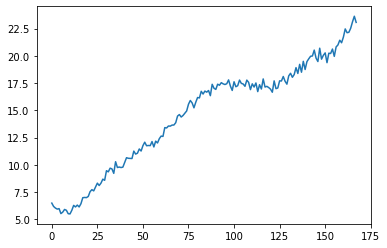

In [ ]:
import matplotlib.pyplot as plt
plt.plot(err)

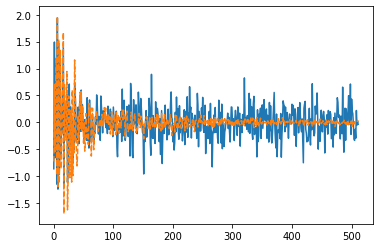

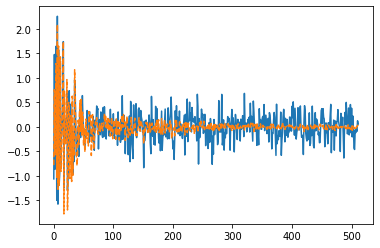

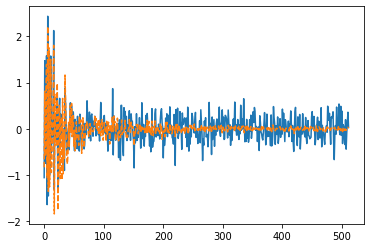

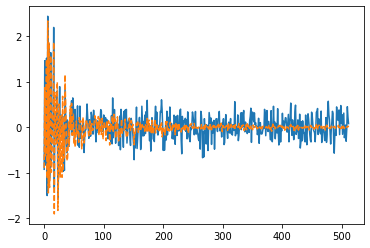

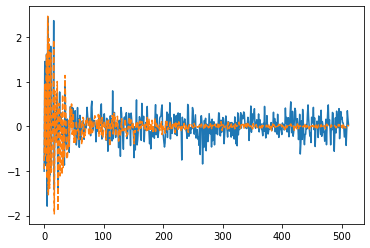

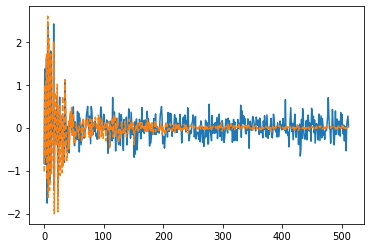

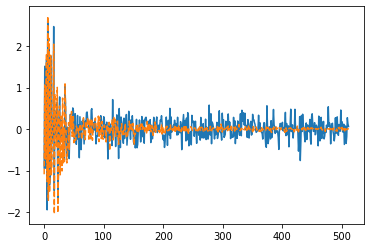

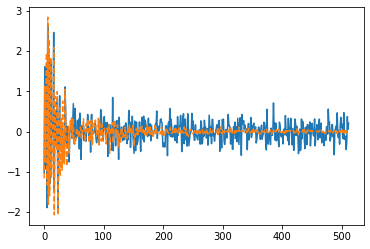

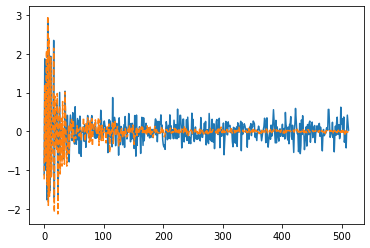

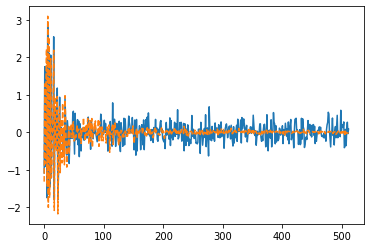

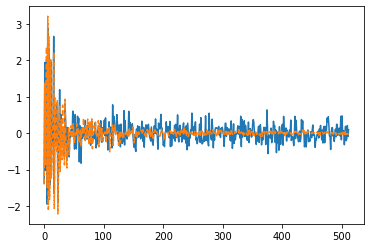

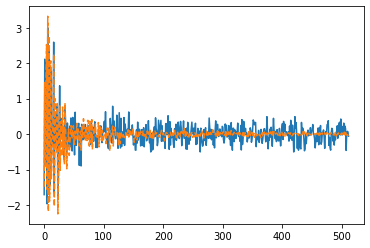

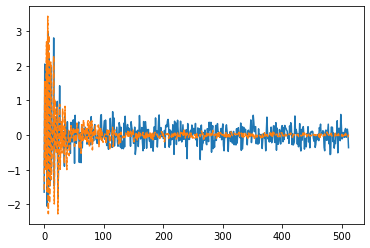

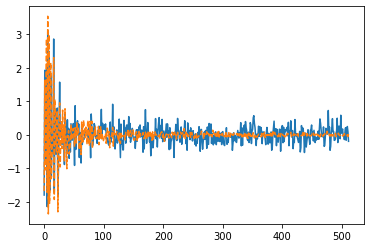

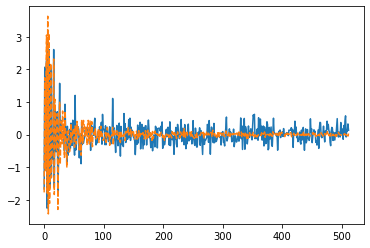

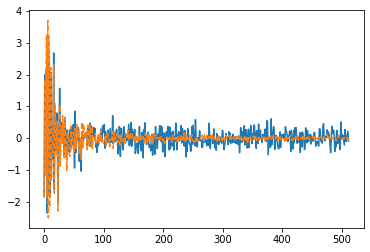

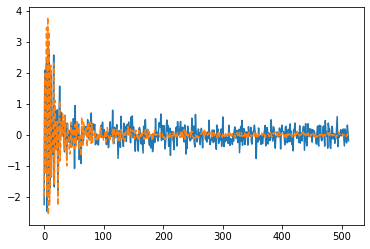

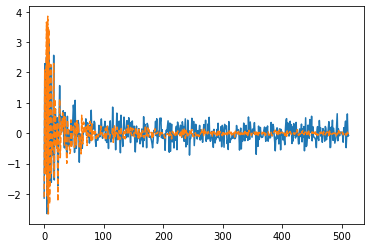

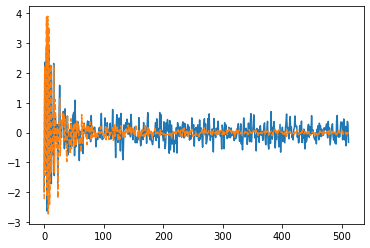

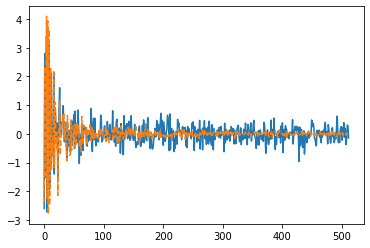

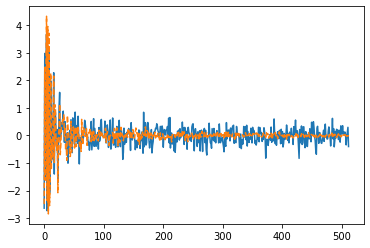

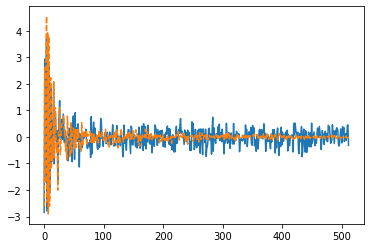

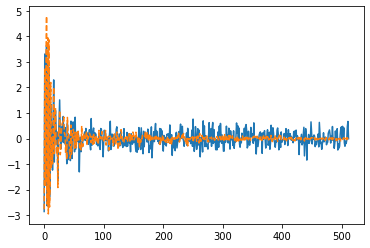

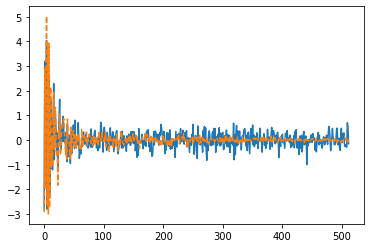

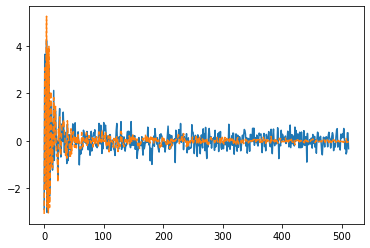

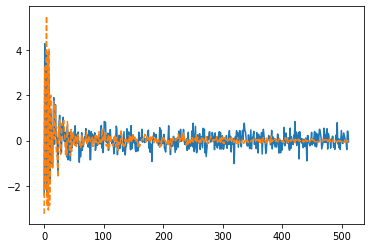

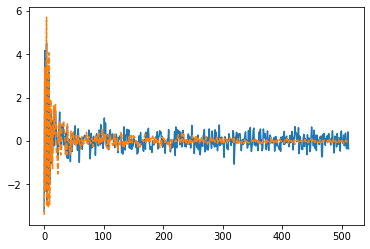

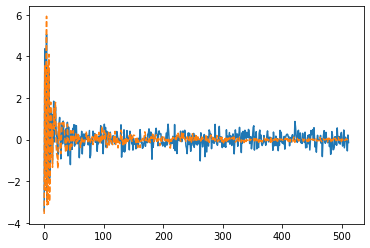

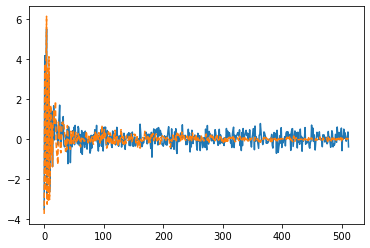

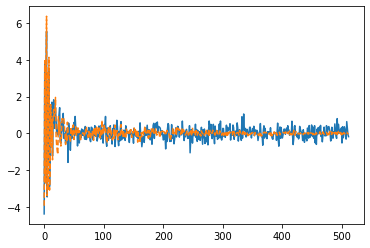

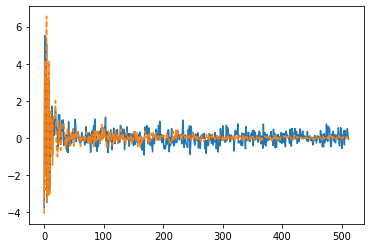

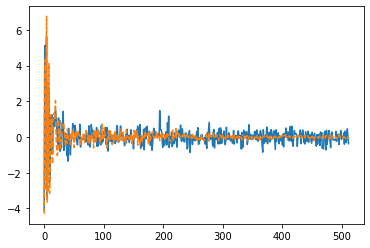

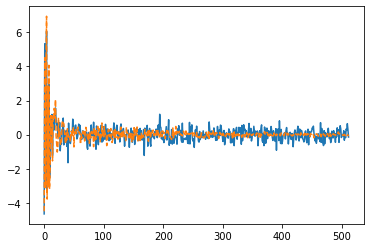

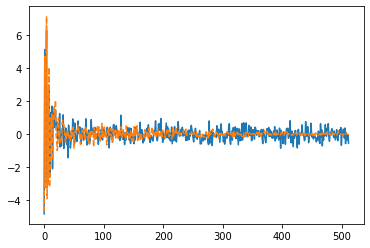

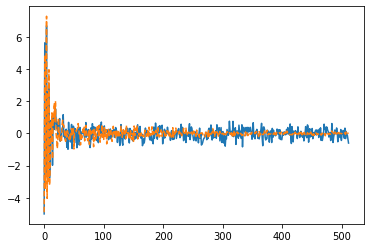

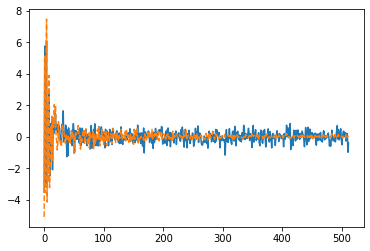

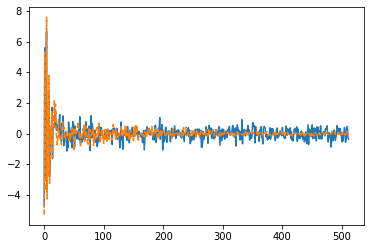

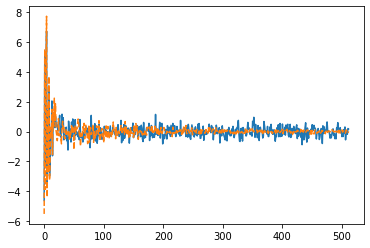

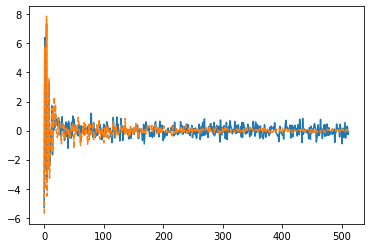

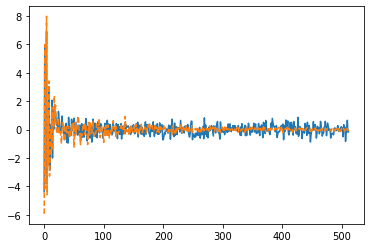

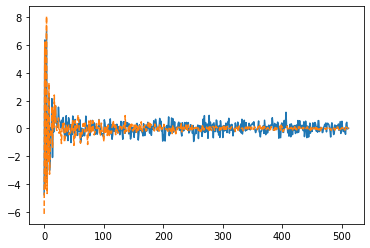

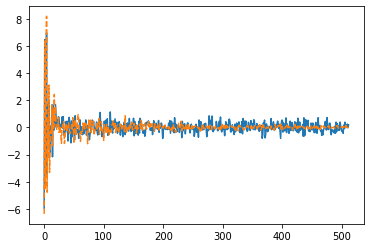

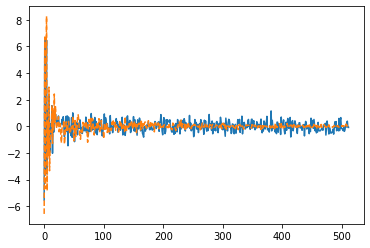

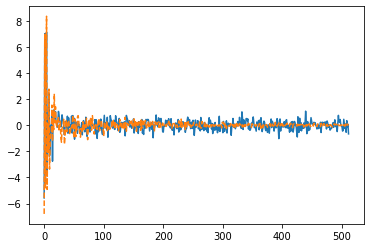

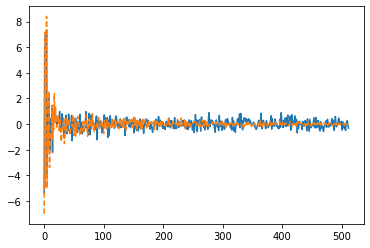

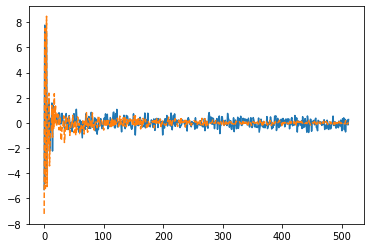

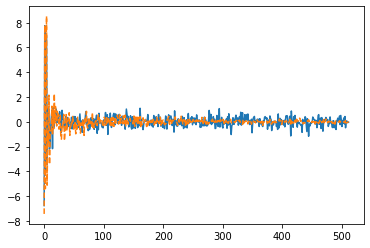

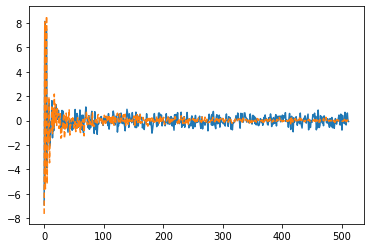

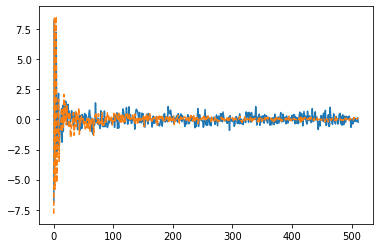

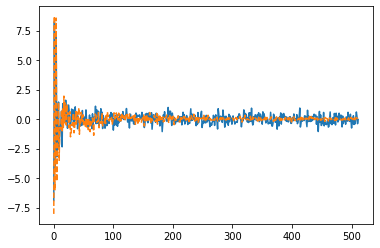

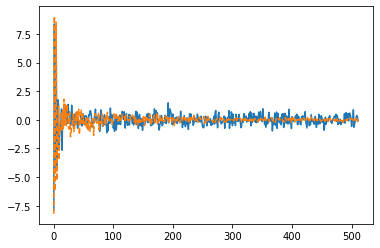

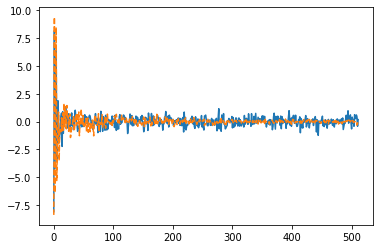

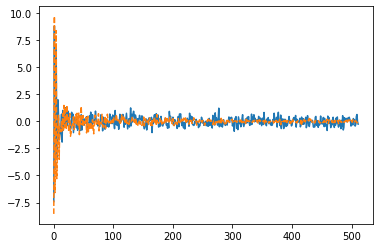

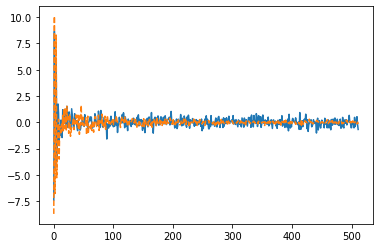

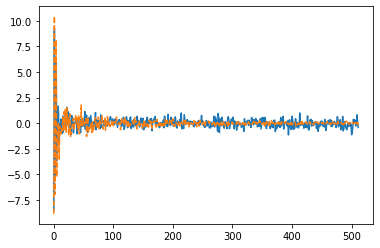

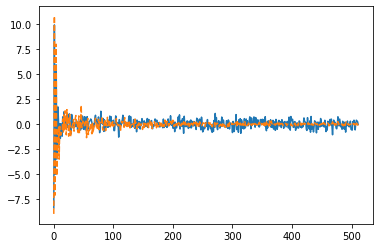

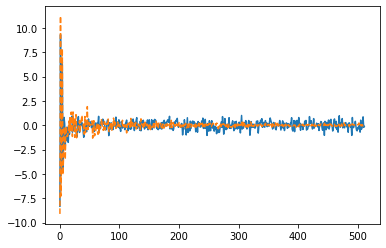

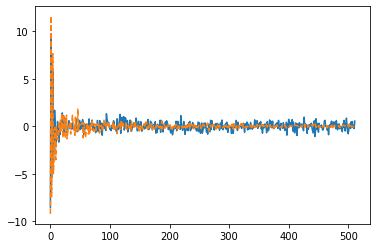

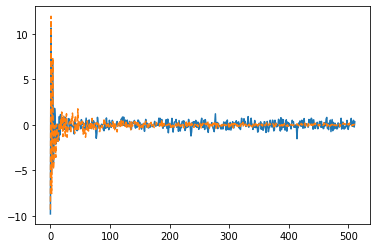

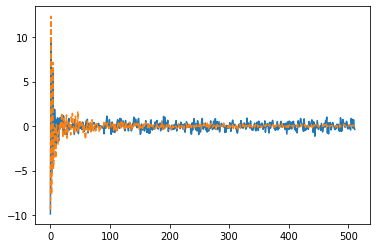

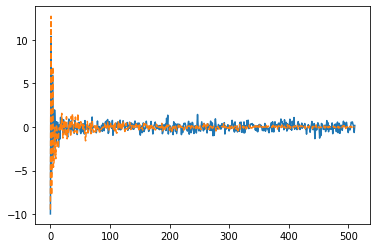

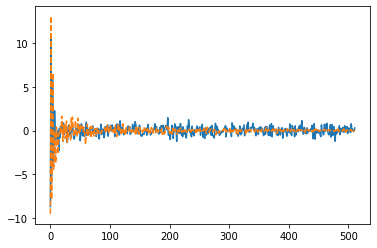

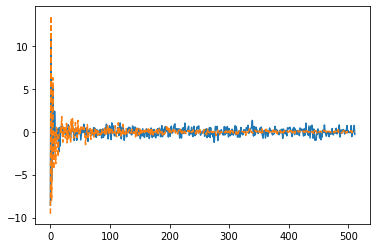

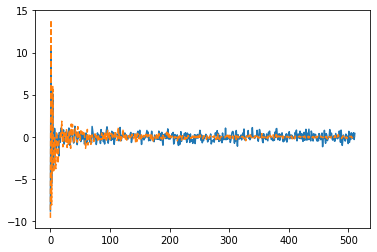

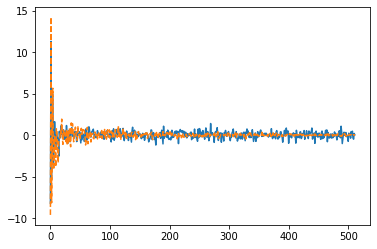

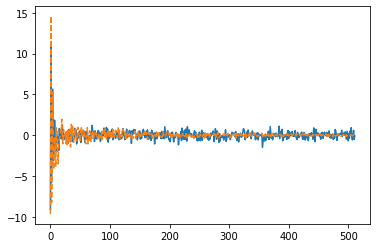

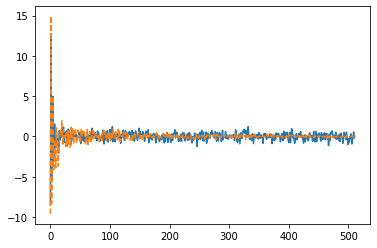

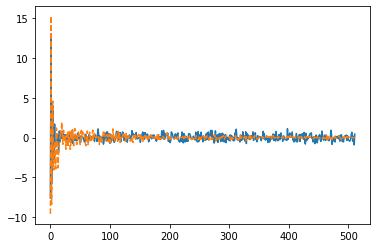

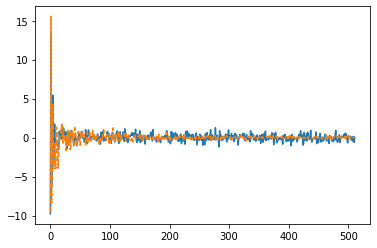

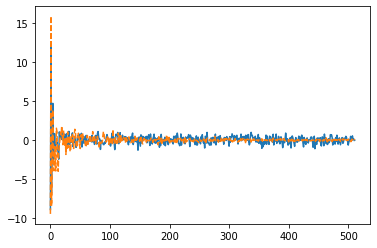

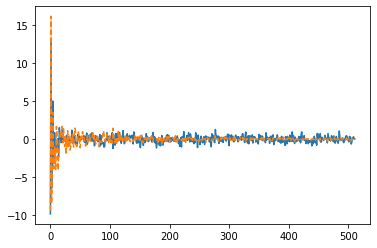

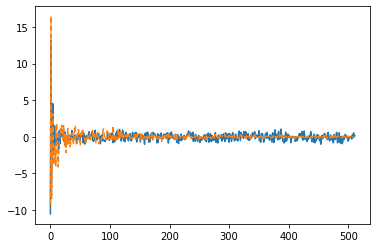

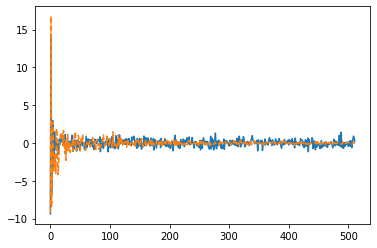

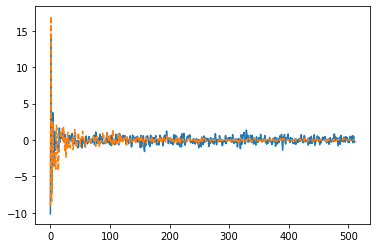

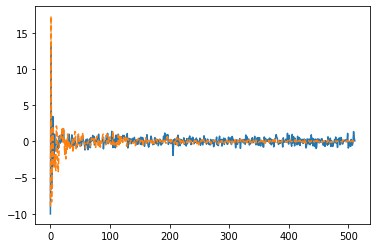

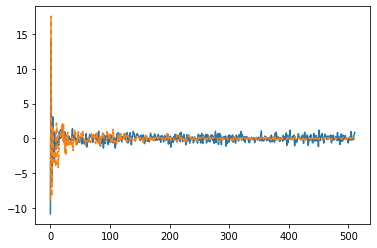

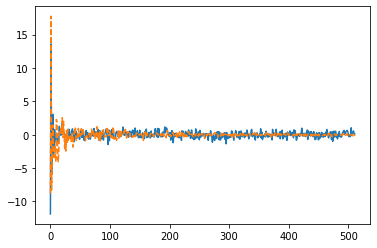

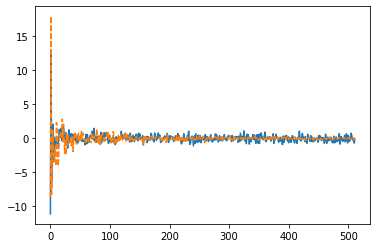

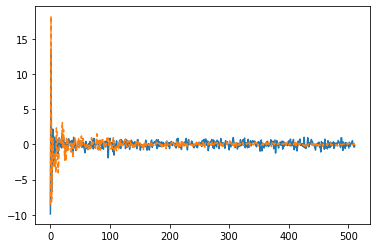

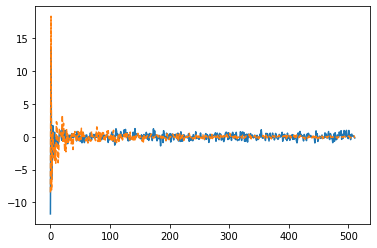

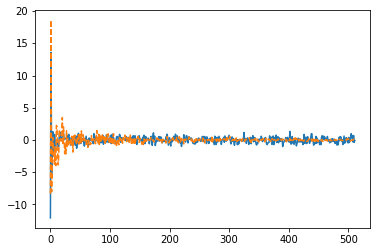

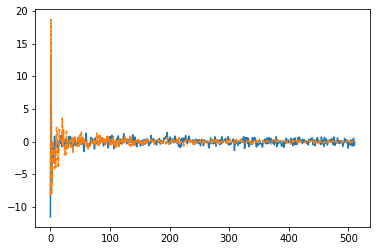

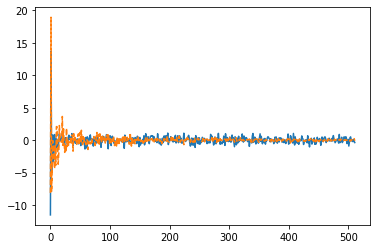

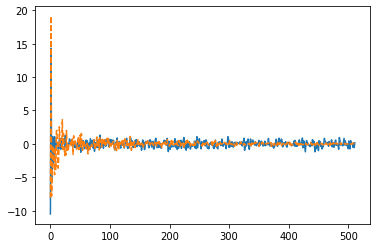

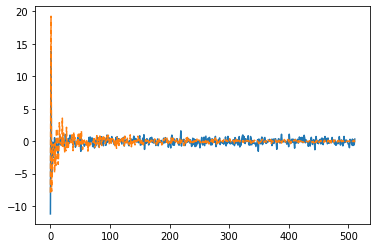

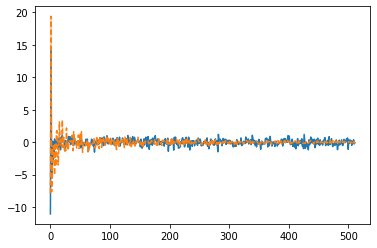

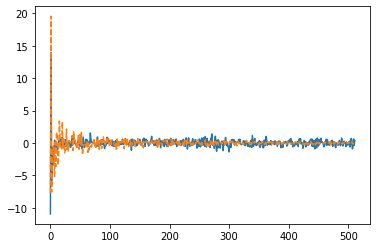

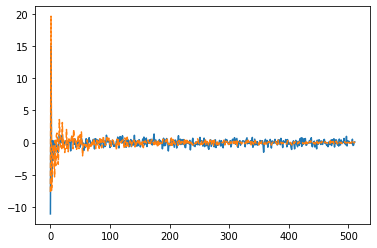

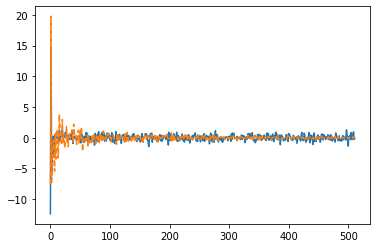

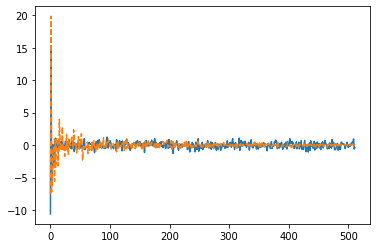

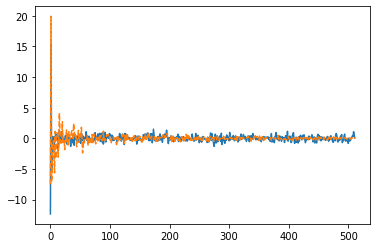

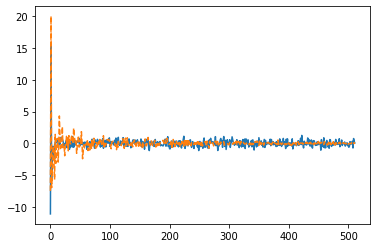

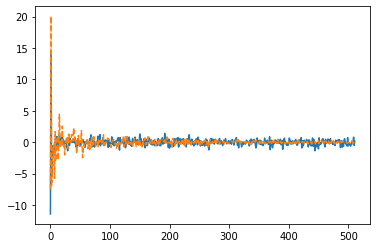

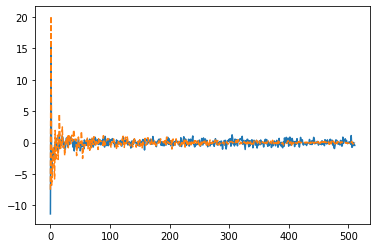

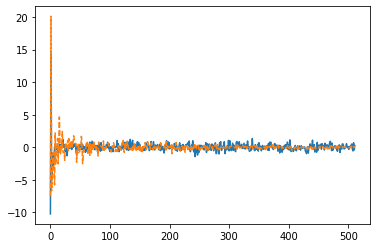

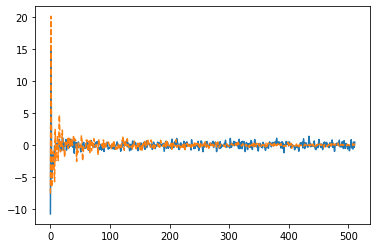

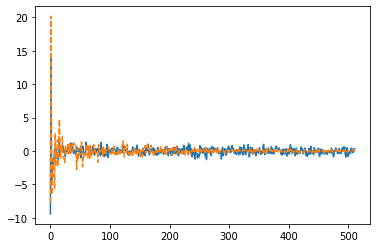

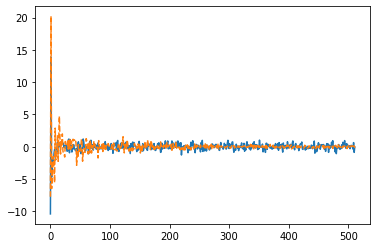

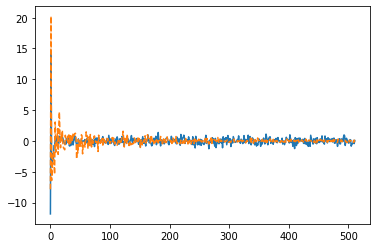

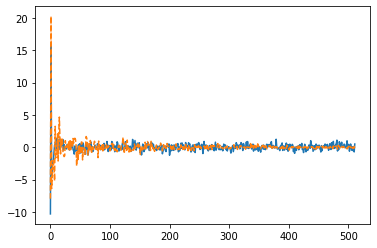

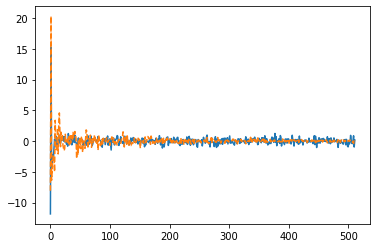

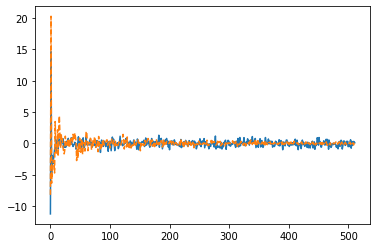

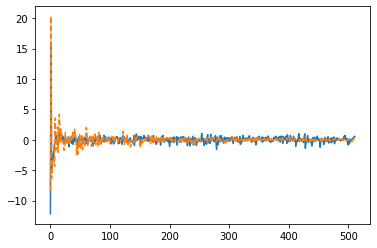

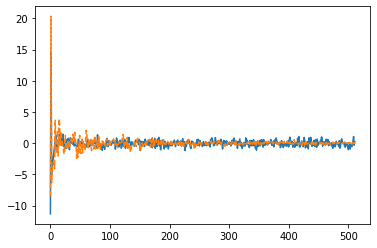

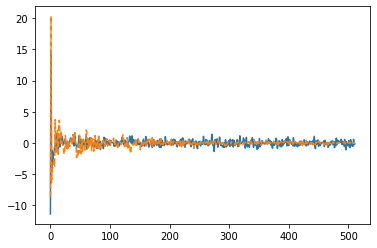

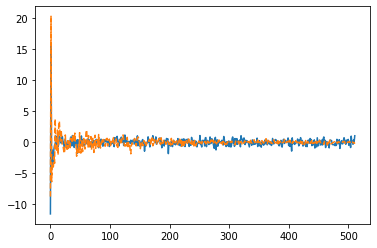

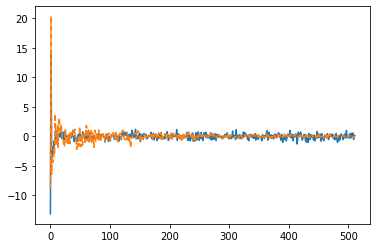

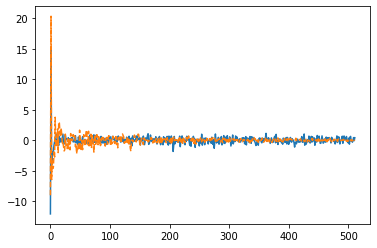

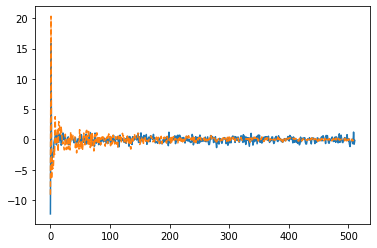

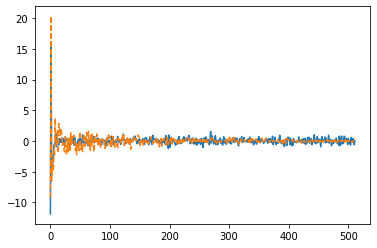

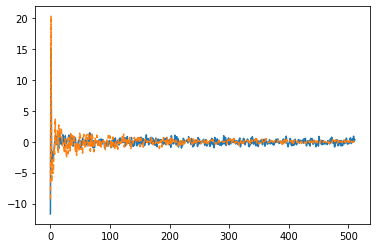

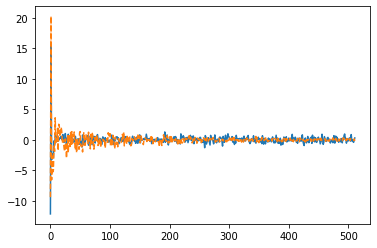

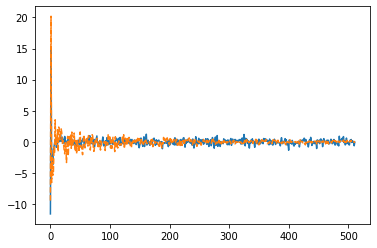

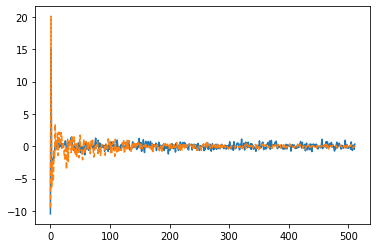

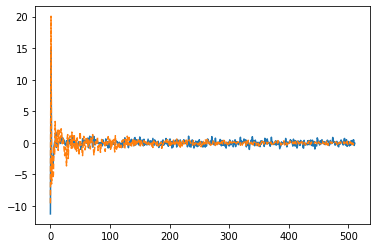

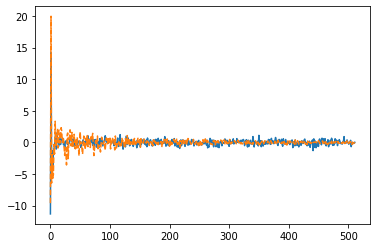

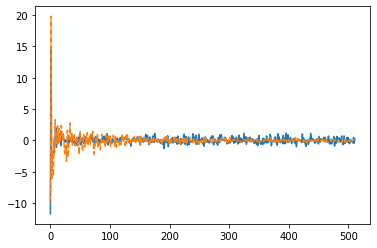

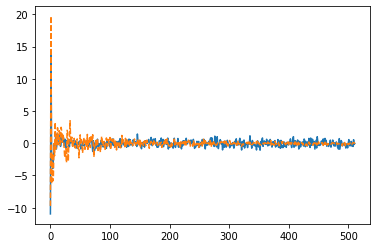

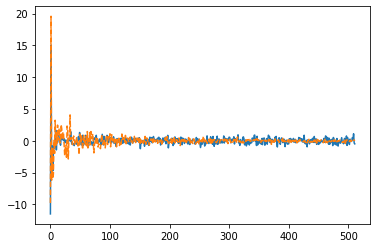

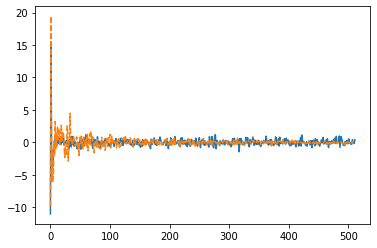

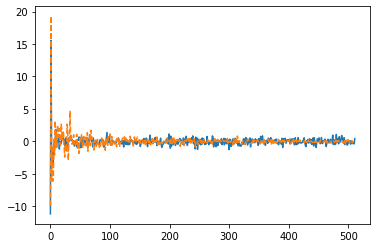

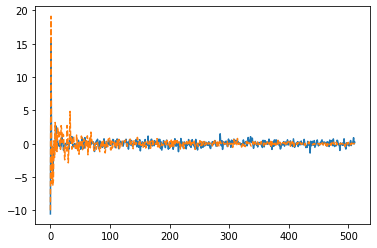

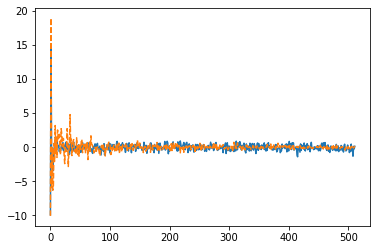

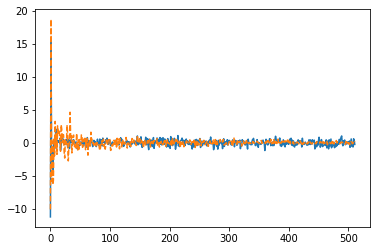

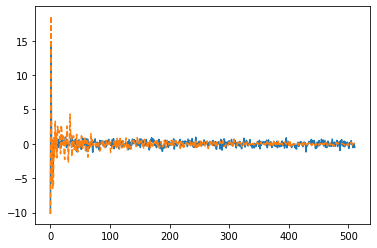

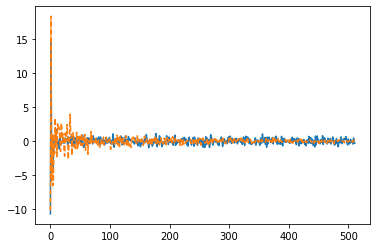

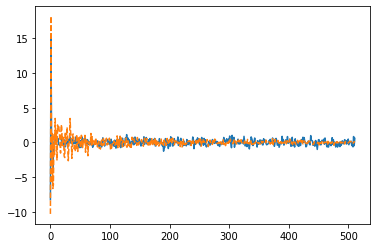

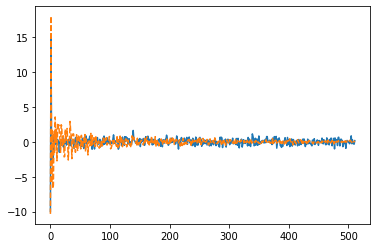

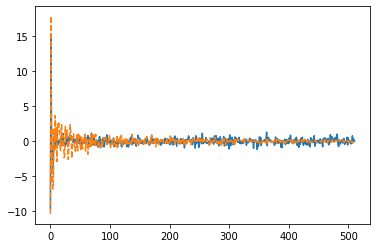

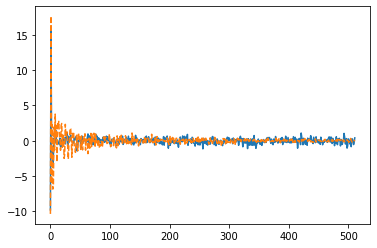

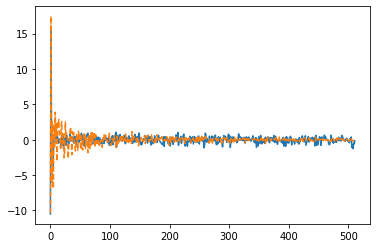

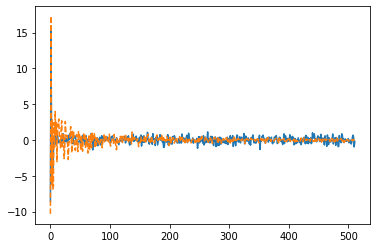

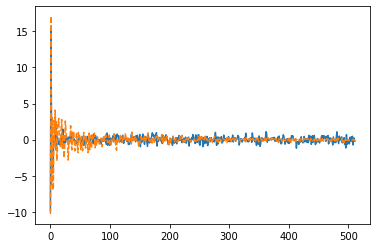

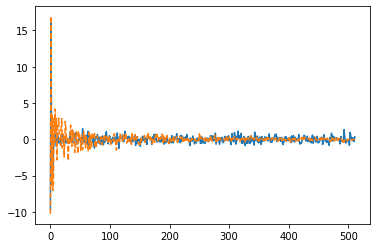

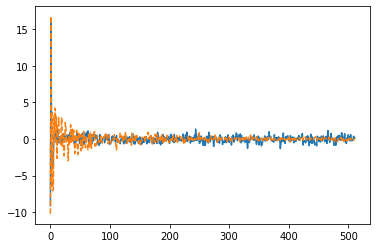

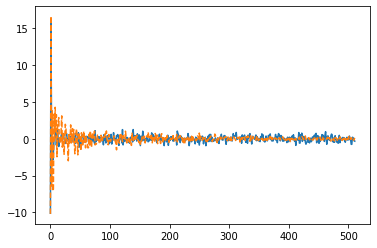

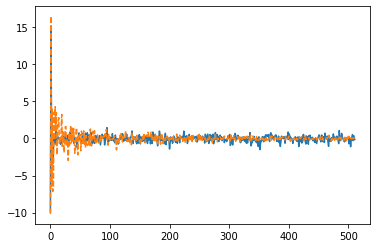

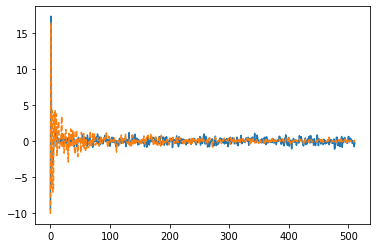

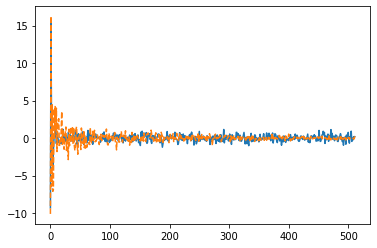

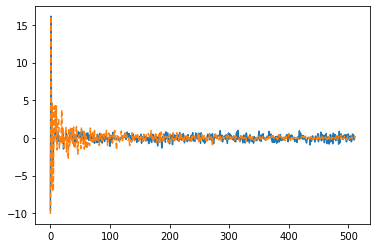

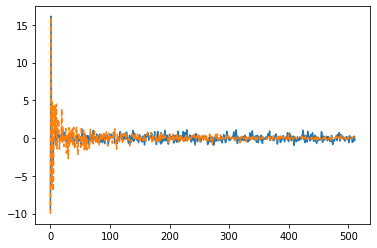

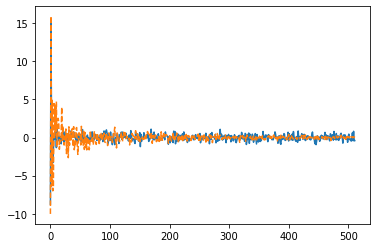

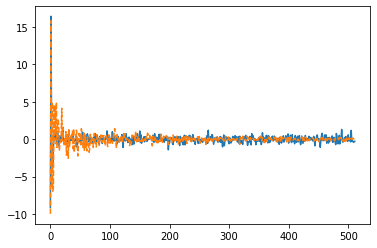

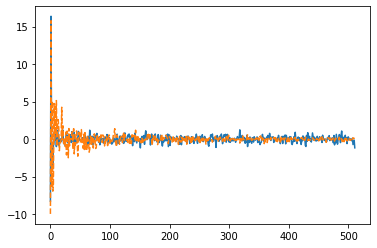

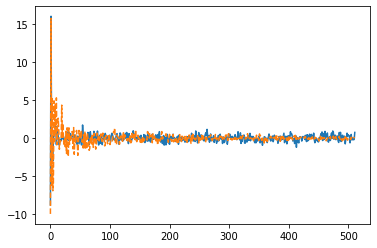

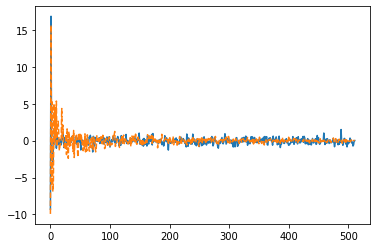

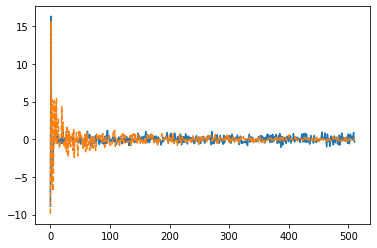

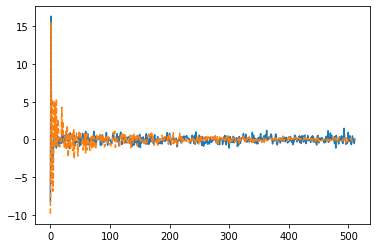

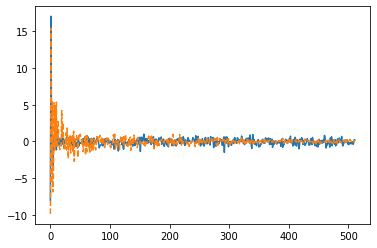

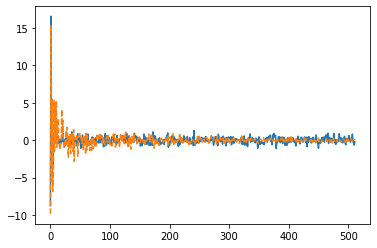

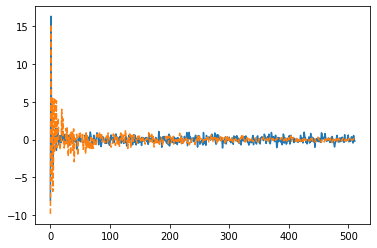

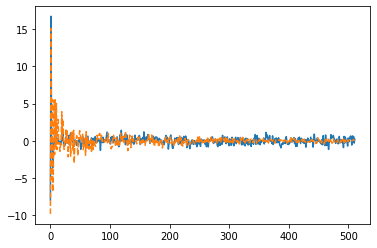

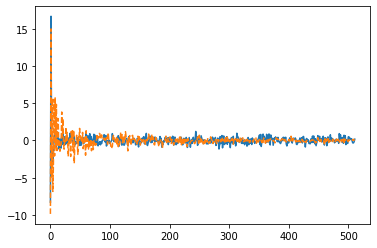

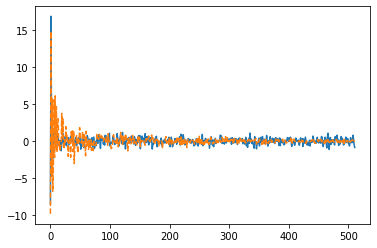

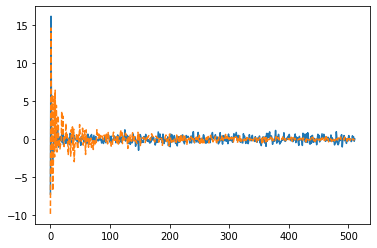

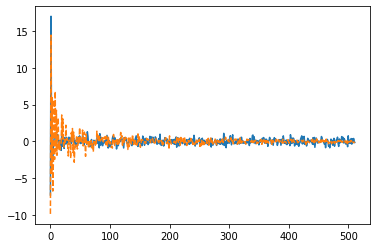

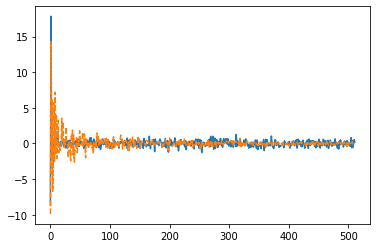

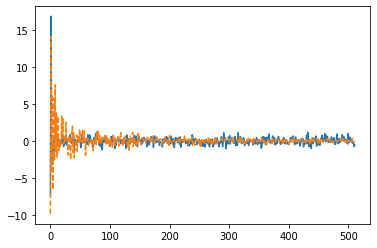

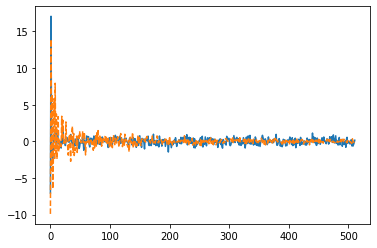

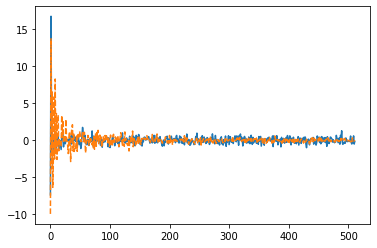

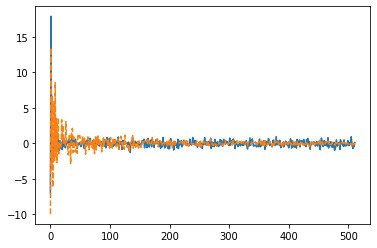

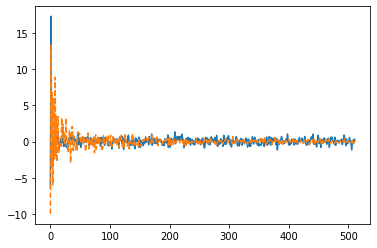

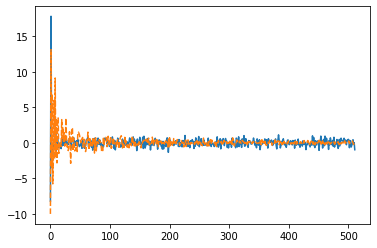

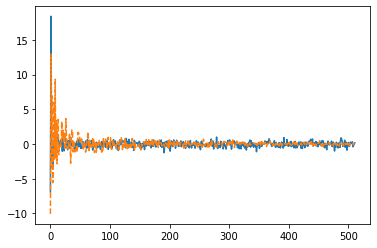

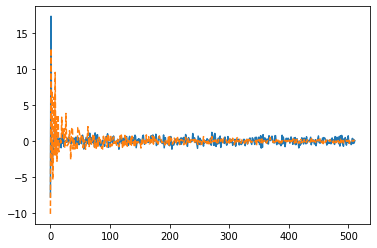

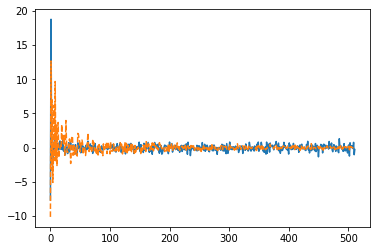

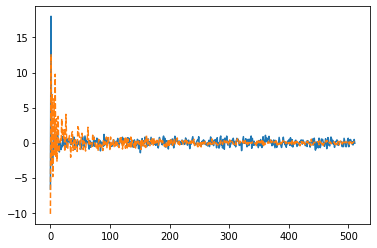

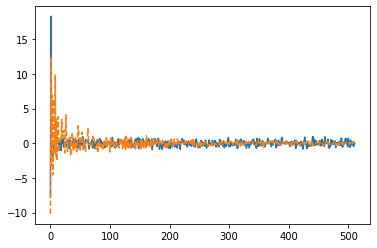

In [ ]:
t = np.arange(512)
for dd,yy in zip(batch_out,y):
    plt.plot(t, dd.detach().cpu().numpy(),t, yy.detach().cpu().numpy(),'--')
    plt.show()

In [ ]:
tmp = y.detach().cpu().numpy()
tmp.max(), tmp.min()

In [ ]:
bb = batch_out.detach().cpu().numpy()
bb.max(), bb.min()

In [ ]:
plt.plot(tmp.max(axis=0))
plt.show()

In [ ]:
plt.plot(d[-2].detach().cpu().numpy())
plt.show()

In [ ]:
from sklearn.manifold import TSNE
X = y.detach().cpu().numpy()
X.shape

In [ ]:
X_embedded = TSNE(n_components=2,verbose=3).fit_transform(X)
X_embedded.shape

In [ ]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=2)
plt.show()

In [ ]:
X = batch_out.detach().cpu().numpy()
X_embedded = TSNE(n_components=2,verbose=3).fit_transform(X)
X_embedded.shape

In [ ]:
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=2)
plt.show()